## MLNS Project Code

## 1. Setup : 

### 1.1. Install Requirements : 

In [1]:
# !pip install numpy==1.23.5 --no-cache-dir
!pip install networkx matplotlib infomap python-louvain node2vec==0.4.6 --no-cache-dir


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from infomap import Infomap
import community.community_louvain as community_louvain
import networkx as nx
from community import community_louvain
from infomap import Infomap
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community.quality import modularity
from time import time
import matplotlib.pyplot as plt
import pandas as pd

### 1.2. Download Facebook Dataset : 

In [3]:
# Facebook dataset :
############################################################################
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz
!gunzip facebook_combined.txt.gz

G_facebook = nx.read_edgelist('facebook_combined.txt')
print("\nFacebook Dataset :")
print("Number of nodes:", G_facebook.number_of_nodes())
print("Number of edges:", G_facebook.number_of_edges())

--2025-04-25 14:55:04--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   149KB/s    in 1.4s    

2025-04-25 14:55:07 (149 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]


Facebook Dataset :
Number of nodes: 4039
Number of edges: 88234


In [4]:
# Function to get basic graph info
def get_graph_info(G):
    print('Number of Nodes:', G.number_of_nodes())
    print('Number of Edges:', G.number_of_edges())
    print('Min Degree:', np.min([degree for _, degree in G.degree()]))
    print('Max Degree:', np.max([degree for _, degree in G.degree()]))
    print('Is Graph Connected?', nx.is_connected(G))
    print('Number of Connected Components:', nx.number_connected_components(G))

# Display basic info
print("\nFacebook Dataset : #######################################")
get_graph_info(G_facebook)



Facebook Dataset : #######################################
Number of Nodes: 4039
Number of Edges: 88234
Min Degree: 1
Max Degree: 1045
Is Graph Connected? True
Number of Connected Components: 1


### 1.3. Community Detection Methodologies : 

In [5]:
from time import time
from community import community_louvain
from infomap import Infomap
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community.quality import modularity

print("\n🔍 Running Community Detection on Facebook")

# ============================
# [1] Louvain Method
# ============================
start = time()
louvain_partition = community_louvain.best_partition(G_facebook)
louvain_time = time() - start
louvain_comms = [set([n for n, c in louvain_partition.items() if c == i]) for i in set(louvain_partition.values())]
louvain_modularity = modularity(G_facebook, louvain_comms)
print(f"[1] Louvain → Time: {louvain_time:.2f}s | Modularity: {louvain_modularity:.4f}")

# ============================
# [2] Label Propagation Algorithm (LPA)
# ============================
start = time()
lpa_communities = list(asyn_lpa_communities(G_facebook))
lpa_time = time() - start
lpa_modularity = modularity(G_facebook, lpa_communities)
print(f"[2] LPA → Time: {lpa_time:.2f}s | Modularity: {lpa_modularity:.4f}")

# ============================
# [3] Infomap Method
# ============================
node_to_id = {node: i for i, node in enumerate(G_facebook.nodes())}
id_to_node = {i: node for node, i in node_to_id.items()}
infomap = Infomap()

for u, v in G_facebook.edges():
    infomap.addLink(node_to_id[u], node_to_id[v])

start = time()
infomap.run()
infomap_time = time() - start

infomap_partition = {
    id_to_node[node.physicalId]: node.moduleIndex()
    for node in infomap.tree if node.isLeaf
}
infomap_comms = [set([n for n, c in infomap_partition.items() if c == i]) for i in set(infomap_partition.values())]
infomap_modularity = modularity(G_facebook, infomap_comms)

print(f"[3] Infomap → Time: {infomap_time:.2f}s | Modularity: {infomap_modularity:.4f}")



🔍 Running Community Detection on Facebook
[1] Louvain → Time: 1.04s | Modularity: 0.8349
[2] LPA → Time: 0.25s | Modularity: 0.8133
  Infomap v2.8.0 starts at 2025-04-25 14:55:09
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 4039 nodes and 88234 links...
  -> One-level codelength: 11.2456758

Trial 1/1 starting at 2025-04-25 14:55:09
Two-level compression: 28% 0.66% 0.0284535488% 
Partitioned to codelength 0.3546428 + 7.72374184 = 8.078384642 in 72 modules.
Super-level compression: 1.35664004% to codelength 7.968790041 in 7 top modules.

Recursive sub-structure compression: 12.2618007% 2.98796625% 0.00411027428% 0% . Found 5 levels with codelength 7.88258583

=> Trial 1/1 finished in 0.179715541s with codelength 7.88258583


Summary after 1 trial
B

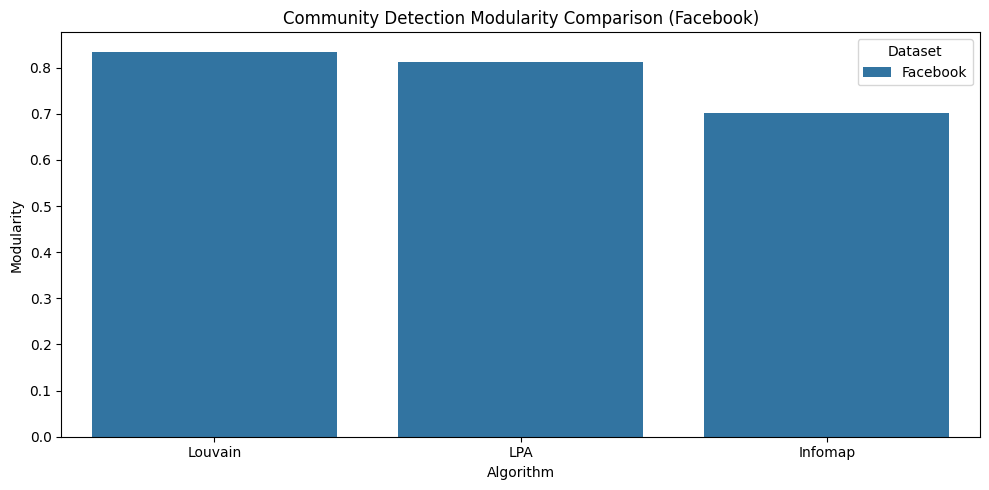

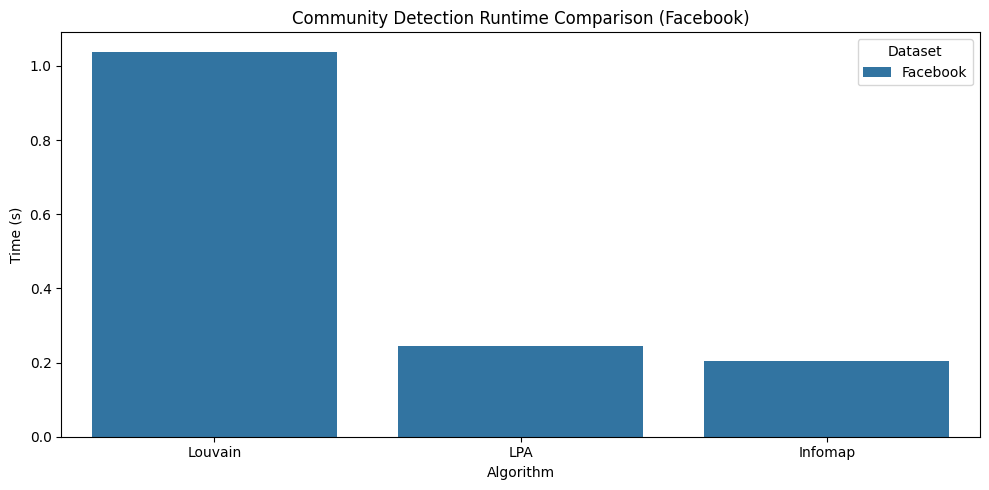

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of Results :
df_fb = pd.DataFrame([
    ["Louvain", louvain_time, louvain_modularity],
    ["LPA", lpa_time, lpa_modularity],
    ["Infomap", infomap_time, infomap_modularity]
], columns=["Algorithm", "Time (s)", "Modularity"])

df_fb["Dataset"] = "Facebook"

# Visualization
#sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
sns.barplot(data=df_fb, x="Algorithm", y="Modularity", hue="Dataset")
plt.title("Community Detection Modularity Comparison (Facebook)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_fb, x="Algorithm", y="Time (s)", hue="Dataset")
plt.title("Community Detection Runtime Comparison (Facebook)")
plt.tight_layout()
plt.show()


## 2. Community Analysis & Visualization of Facebook Dataset

### 2.1. Visual Analysis of Communities and Graph Structure :

In [7]:
# ---------------------------
# Community Size Distribution
# ---------------------------
def plot_community_size_distribution(partition, title="Community Size Distribution"):
    community_sizes = Counter(partition.values())
    colors = plt.cm.tab20c(np.linspace(0, 1, len(community_sizes)))

    plt.figure(figsize=(12, 6))
    plt.bar(community_sizes.keys(), community_sizes.values(), color=colors)
    plt.xlabel("Community ID")
    plt.ylabel("Number of Nodes")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --------------------
# Degree Distribution
# --------------------
def plot_degree_distribution(G):
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(12, 6))
    plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50),
             color='steelblue', alpha=0.7)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.title("Degree Distribution of Facebook Graph (Log-Log Scale)")
    plt.tight_layout()
    plt.show()

# --------------------
# Community Densities
# --------------------
def plot_community_density(G, partition, title="Community Density"):
    community_subgraphs = {comm: [] for comm in set(partition.values())}
    for node, comm in partition.items():
        community_subgraphs[comm].append(node)

    community_densities = {
        comm: nx.density(G.subgraph(nodes)) for comm, nodes in community_subgraphs.items()
    }

    plt.figure(figsize=(12, 6))
    plt.bar(community_densities.keys(), community_densities.values(), color='darkgreen')
    plt.xlabel("Community ID")
    plt.ylabel("Density")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --------------------
# Top 5 Community Plot
# --------------------
def visualize_top_communities(G, partition, title="Top 5 Largest Communities"):
    community_sizes = Counter(partition.values())
    top_communities = [comm for comm, _ in community_sizes.most_common(5)]

    top_nodes = [node for node, comm in partition.items() if comm in top_communities]
    G_sub = G.subgraph(top_nodes)

    pos = nx.spring_layout(G_sub, seed=42)
    colors = [partition[node] for node in G_sub.nodes()]

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
    nx.draw_networkx_nodes(G_sub, pos, node_size=30, node_color=colors, cmap='tab20')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Method 1 : 

In [8]:
def community_list_to_partition_dict(communities):
    """Convert a list of sets (LPA, Infomap) into a node:community dict"""
    partition = {}
    for i, comm in enumerate(communities):
        for node in comm:
            partition[node] = i
    return partition

def visualize_all_methods(G, method_partitions):
    """
    G: NetworkX graph
    method_partitions: dict of {"method_name": partition_dict or list of sets}
    """
    plot_degree_distribution(G)

    for method, part in method_partitions.items():
        # Normalize format :
        if isinstance(part, list):  # community list
            part_dict = community_list_to_partition_dict(part)
        else:
            part_dict = part

        print(f"\nVisualizing results for {method} : ####################################### ")
        plot_community_size_distribution(part_dict, title=f"{method} – Community Size Distribution")
        plot_community_density(G, part_dict, title=f"{method} – Community Densities")
        visualize_top_communities(G, part_dict, title=f"{method} – Top 5 Communities")


  Infomap v2.8.0 starts at 2025-04-25 14:55:12
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 4039 nodes and 88234 links...
  -> One-level codelength: 11.2456758

Trial 1/1 starting at 2025-04-25 14:55:12
Two-level compression: 28% 0.66% 0.0284535488% 
Partitioned to codelength 0.3546428 + 7.72374184 = 8.078384642 in 72 modules.
Super-level compression: 1.35664004% to codelength 7.968790041 in 7 top modules.

Recursive sub-structure compression: 12.2618007% 2.98796625% 0.00411027428% 0% . Found 5 levels with codelength 7.88258583

=> Trial 1/1 finished in 0.174621292s with codelength 7.88258583


Summary after 1 trial
Best end modular solution in 5 levels:
Per level number of modules:         [          7,         101,          42,           3,      

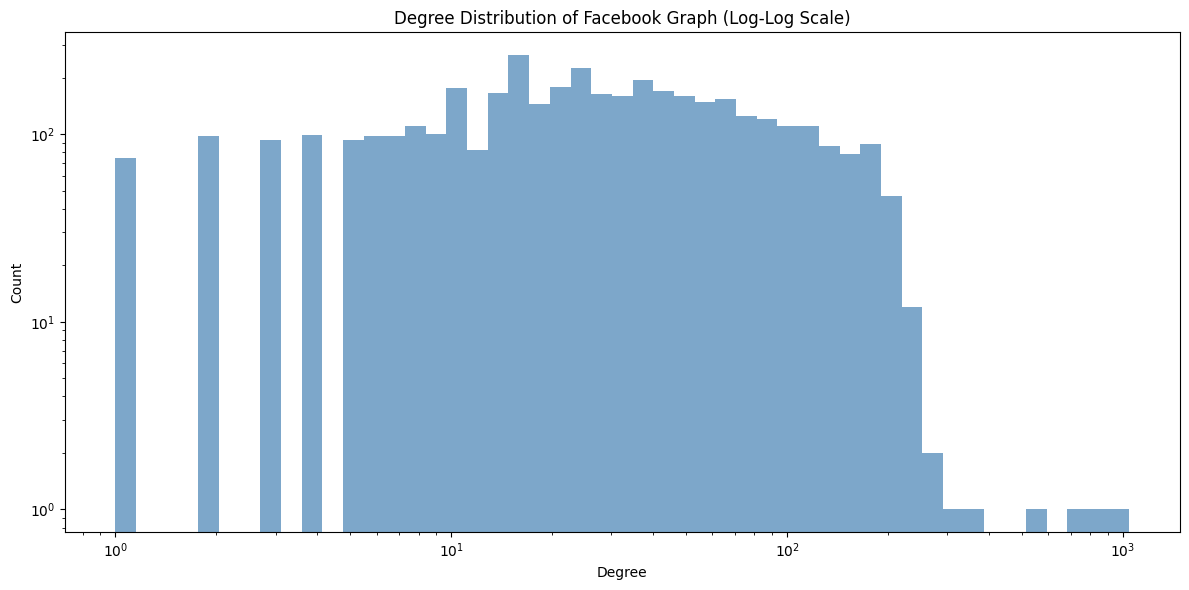


Visualizing results for Louvain : ####################################### 


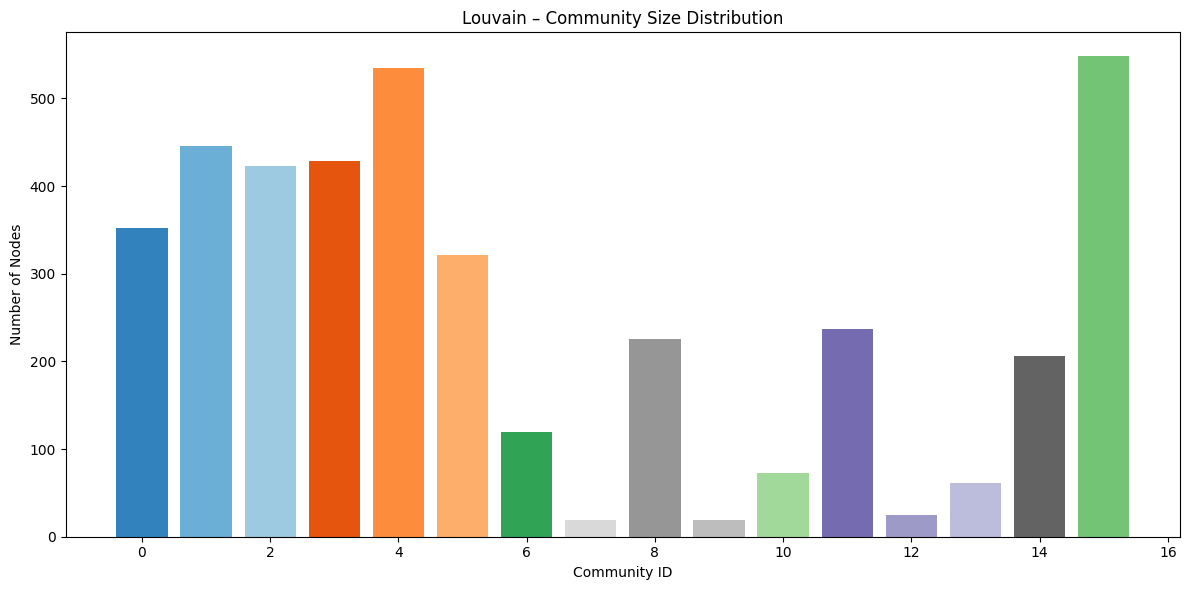

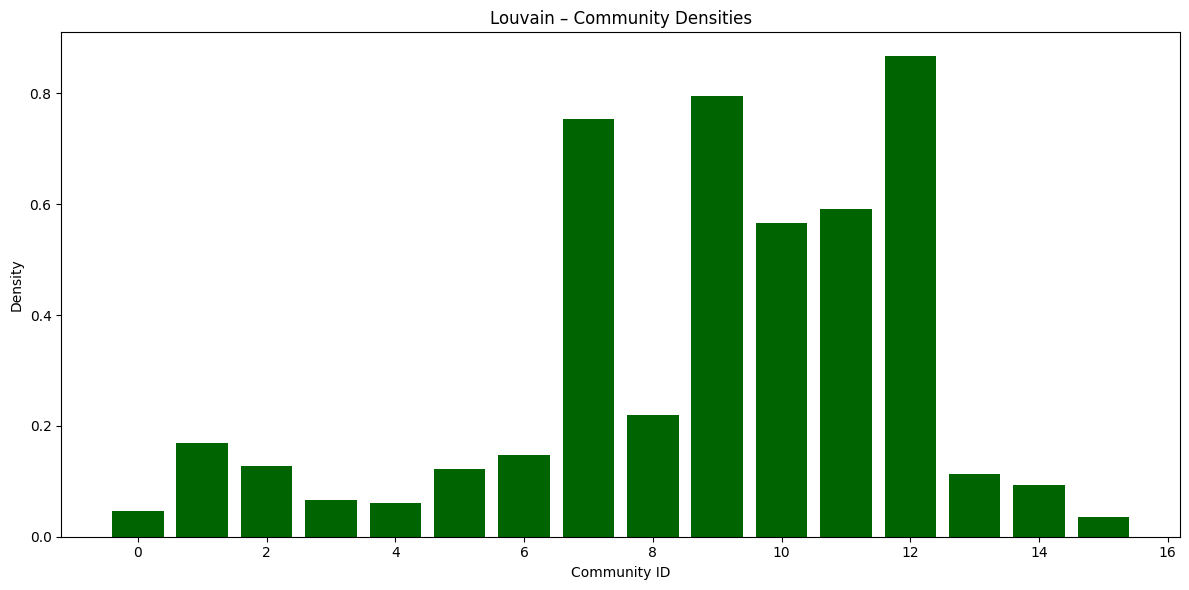

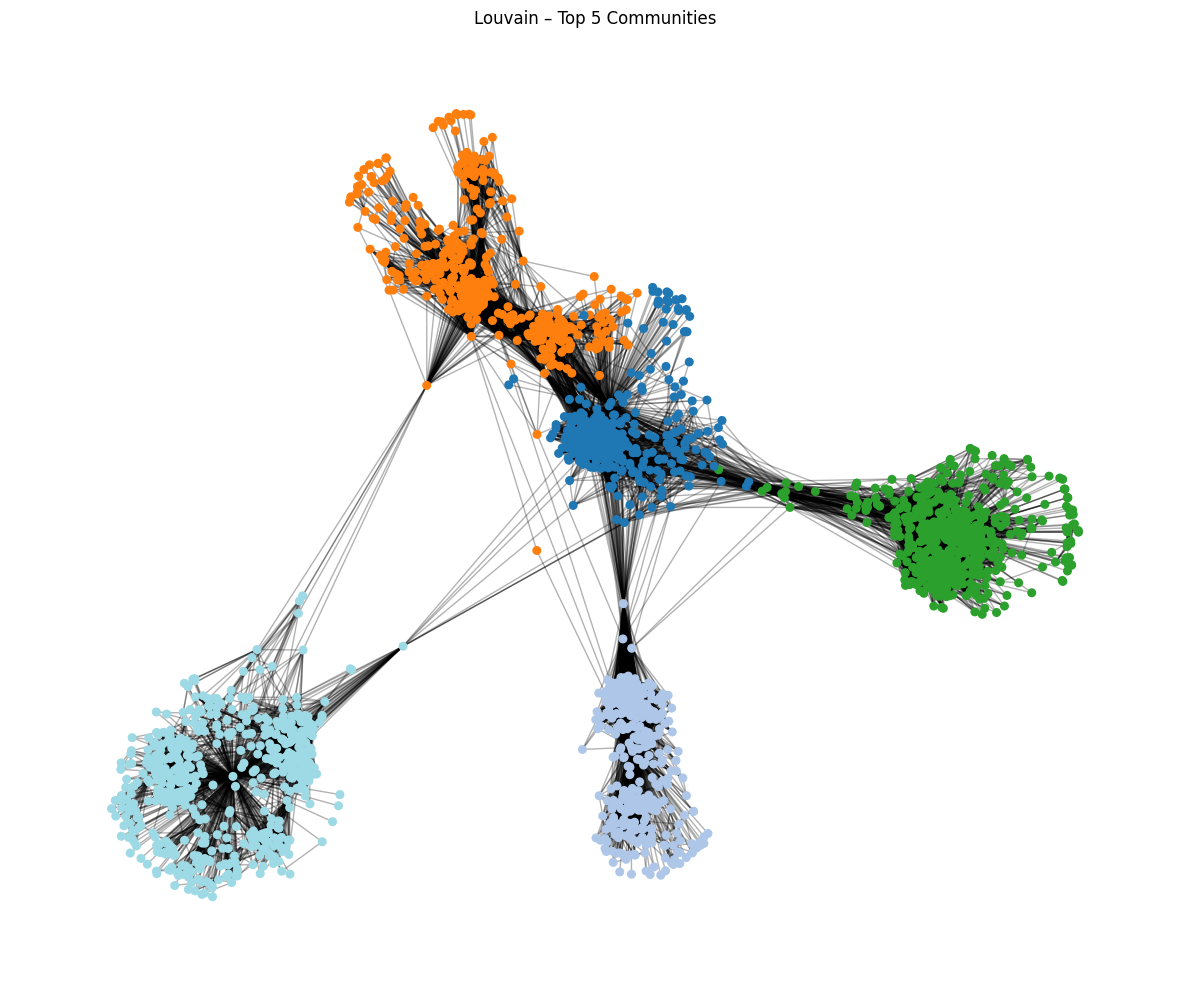


Visualizing results for LPA : ####################################### 


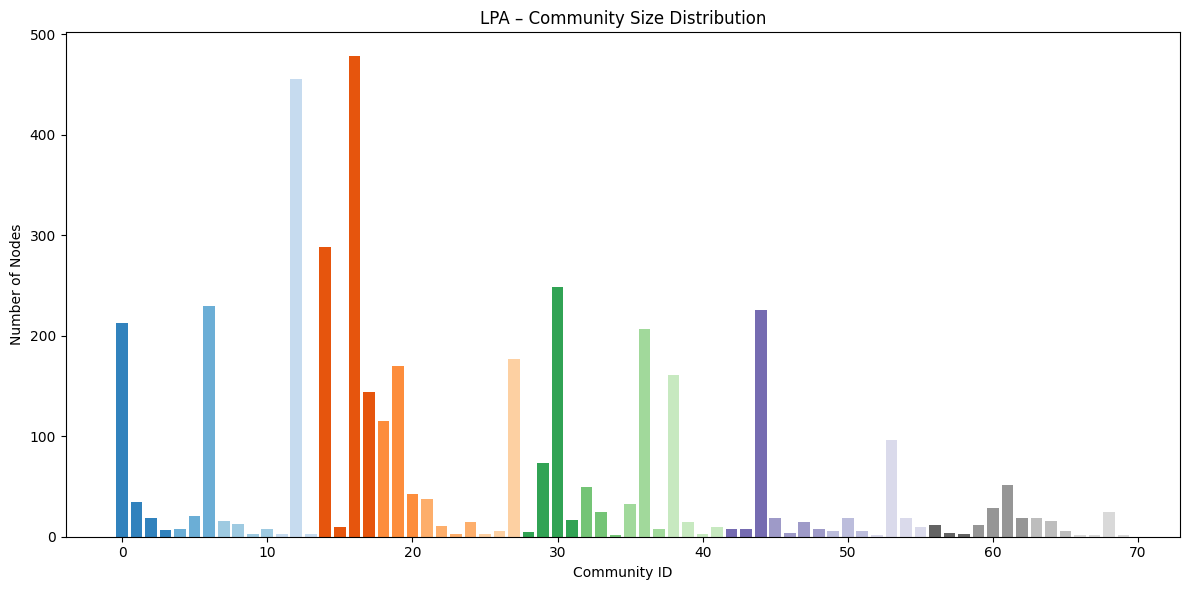

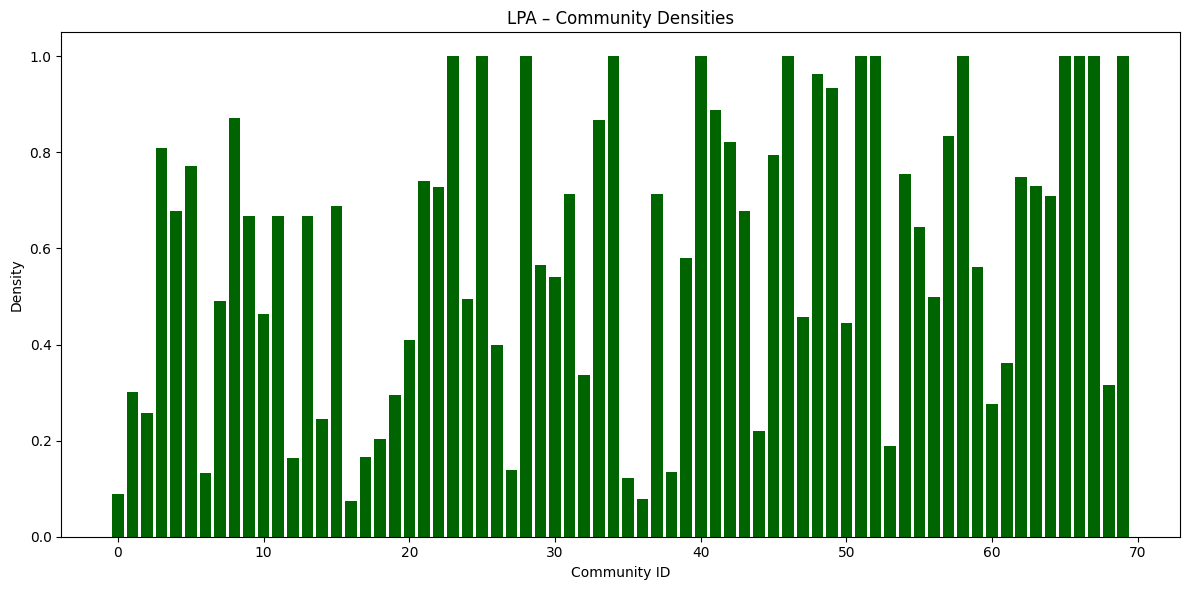

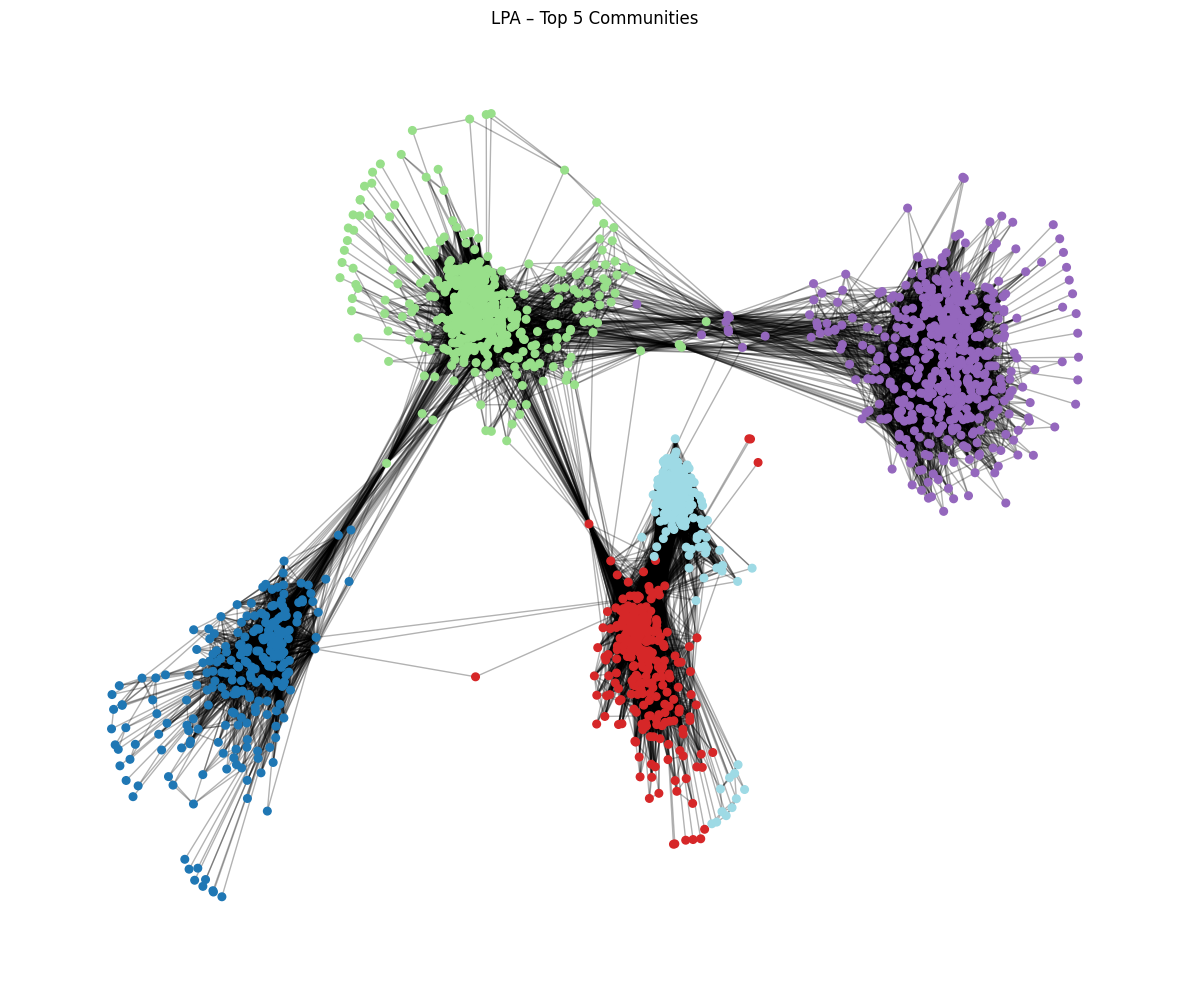


Visualizing results for Infomap : ####################################### 


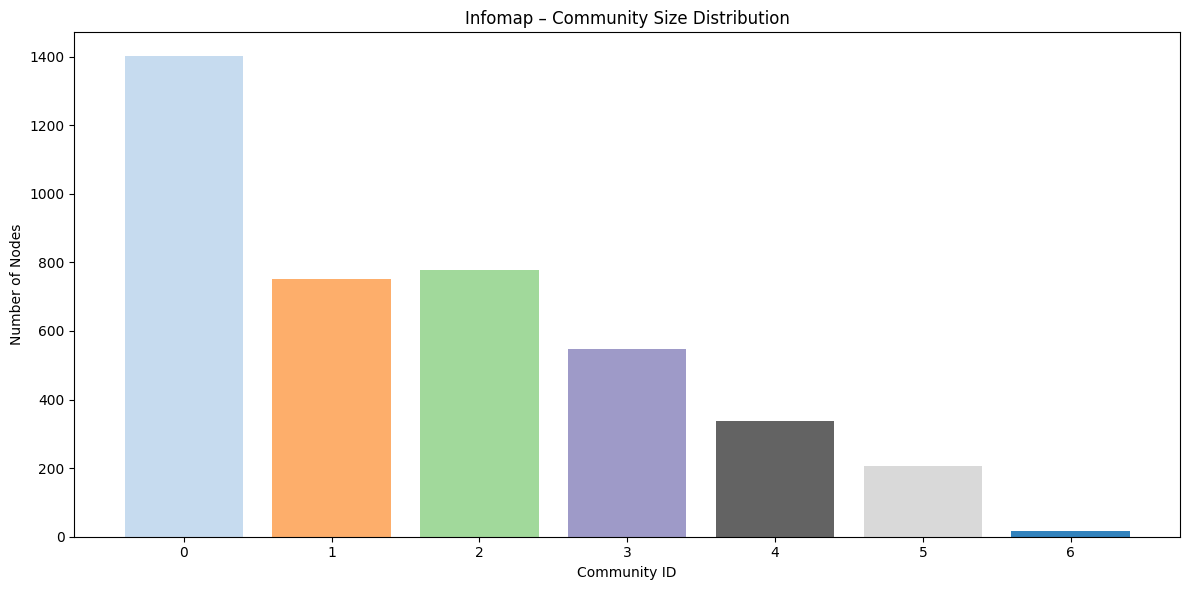

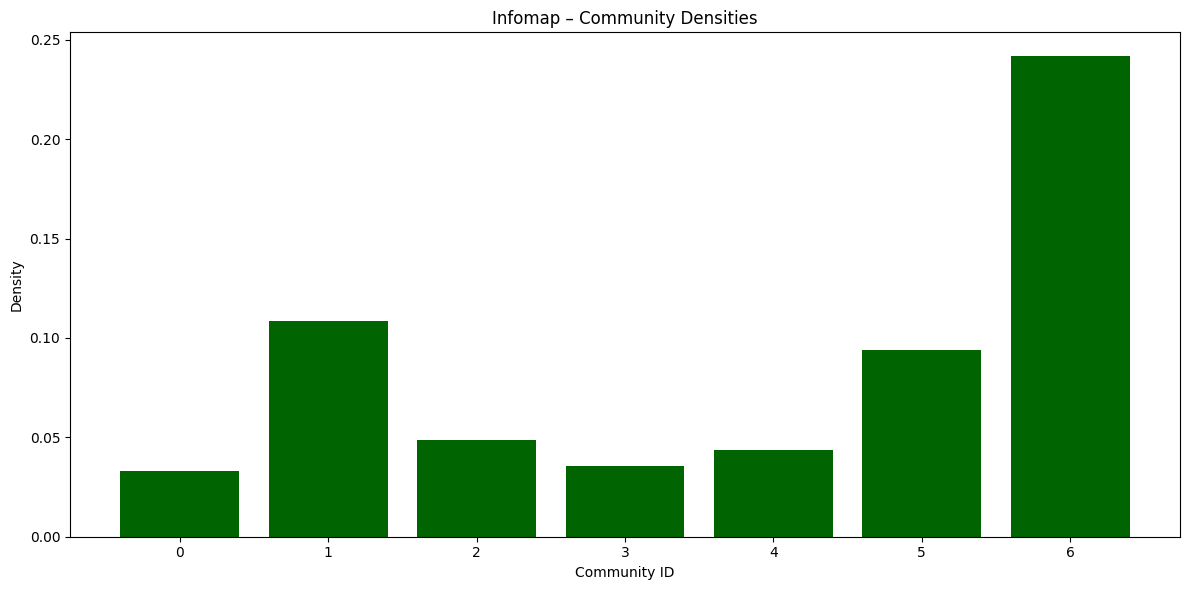

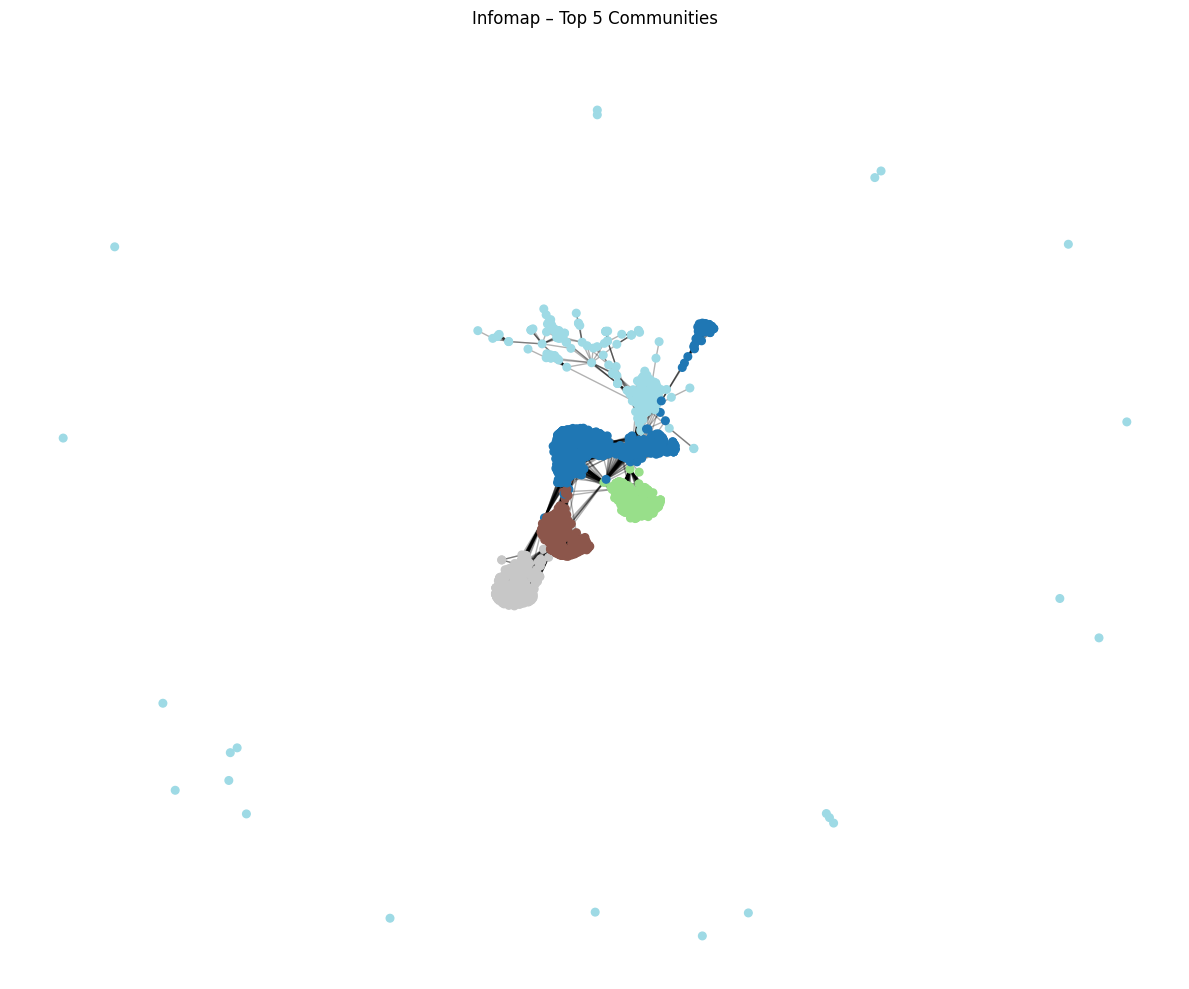

In [9]:
# Run detection  :
louvain_partition = community_louvain.best_partition(G_facebook)
lpa_communities = list(asyn_lpa_communities(G_facebook))

# Infomap with leaf filtering
node_to_id = {node: i for i, node in enumerate(G_facebook.nodes())}
id_to_node = {i: node for node, i in node_to_id.items()}
infomap = Infomap()
for u, v in G_facebook.edges():
    infomap.addLink(node_to_id[u], node_to_id[v])
infomap.run()
infomap_partition_dict = {
    id_to_node[node.physicalId]: node.moduleIndex()
    for node in infomap.tree if node.isLeaf
}

# Prepare partition dictionary
method_results = {
    "Louvain": louvain_partition,
    "LPA": lpa_communities,
    "Infomap": infomap_partition_dict
}

# Visualize
visualize_all_methods(G_facebook, method_results)

### 2.2 Central Node Visualization :


Centrality analysis for Louvain : ####################################### 


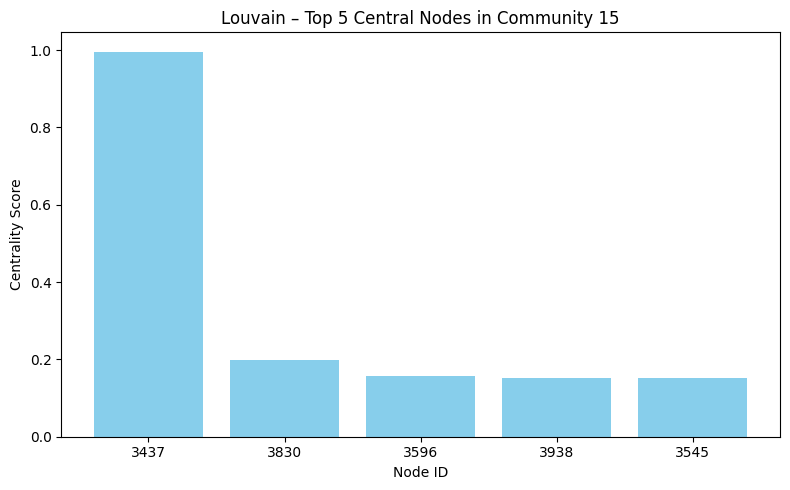

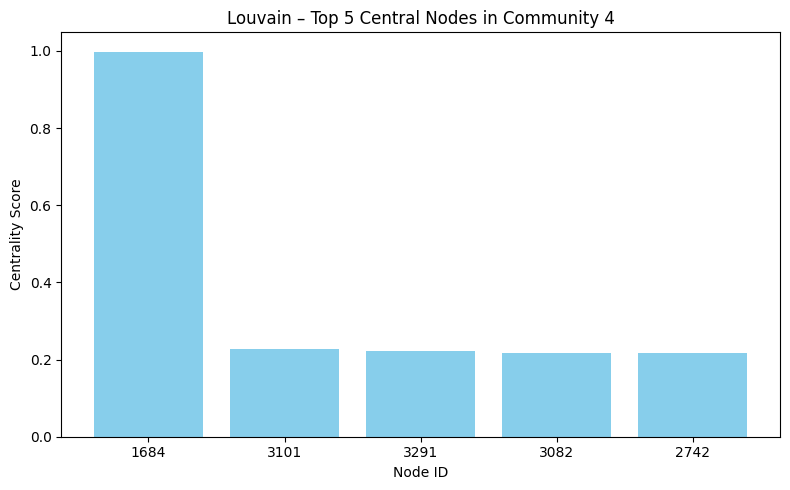

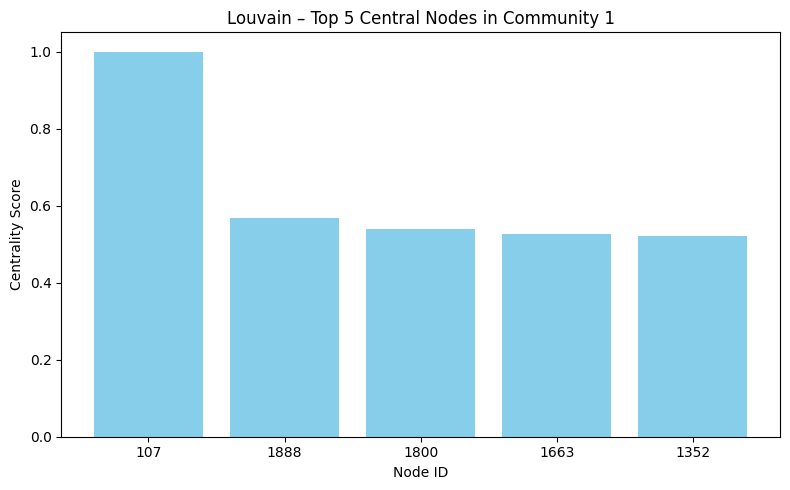

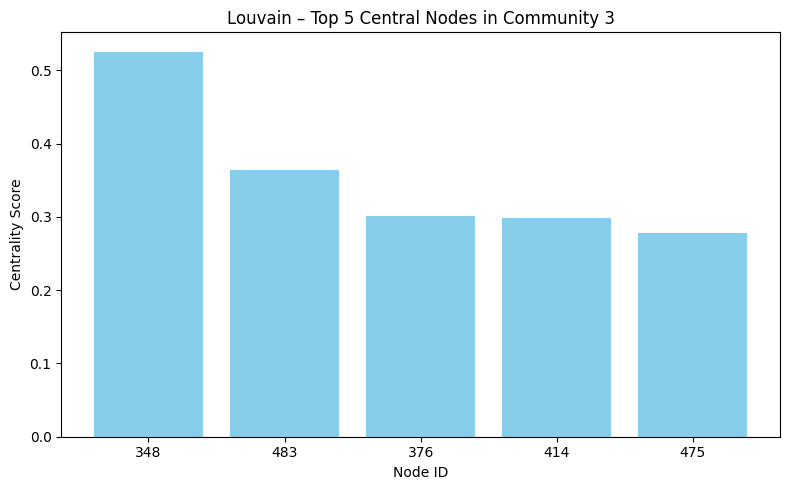

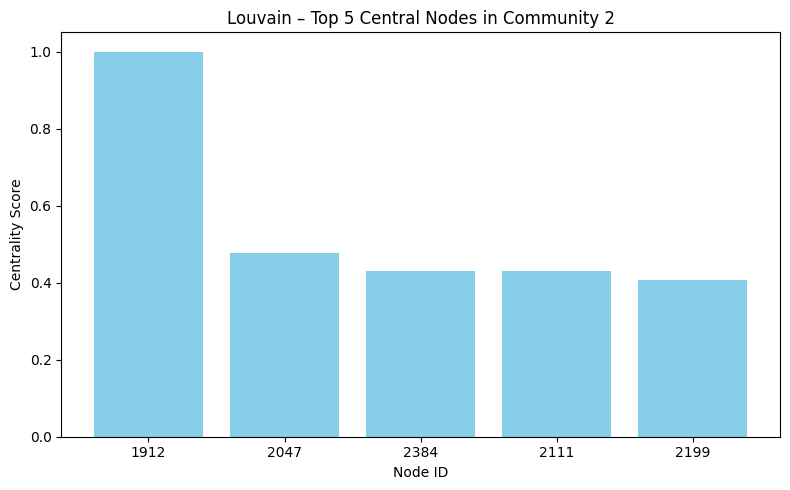


Centrality analysis for LPA : ####################################### 


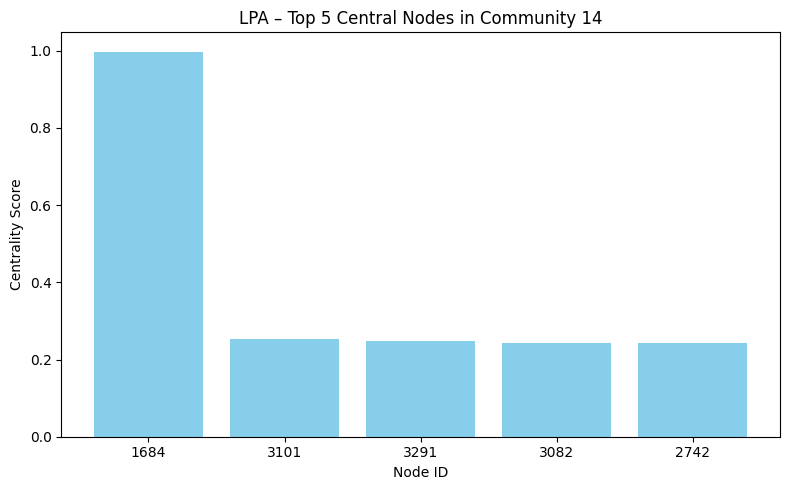

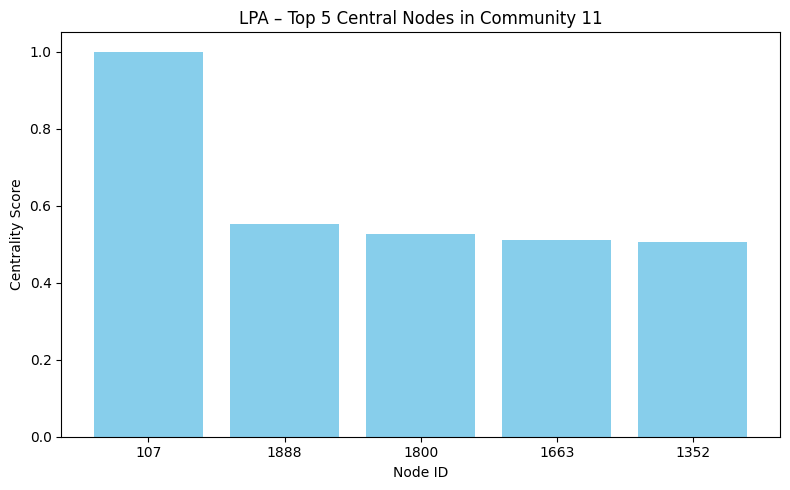

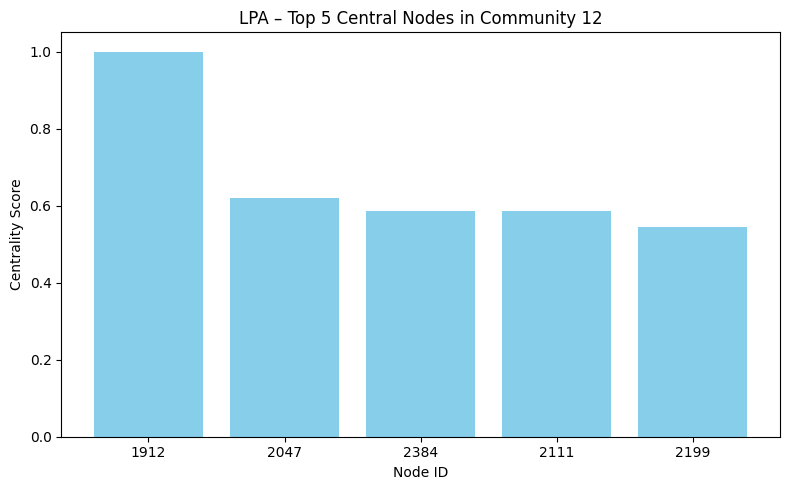

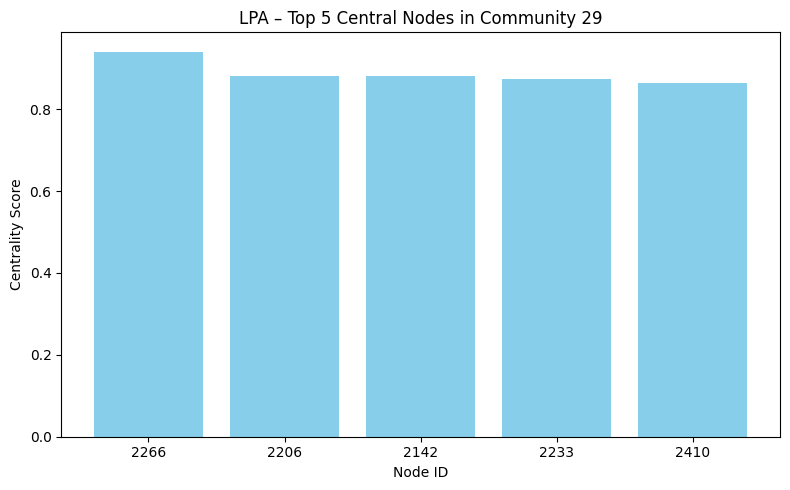

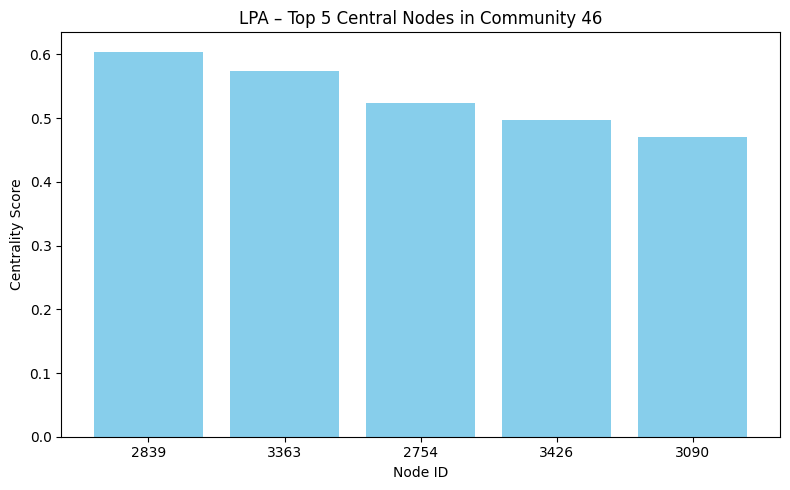


Centrality analysis for Infomap : ####################################### 


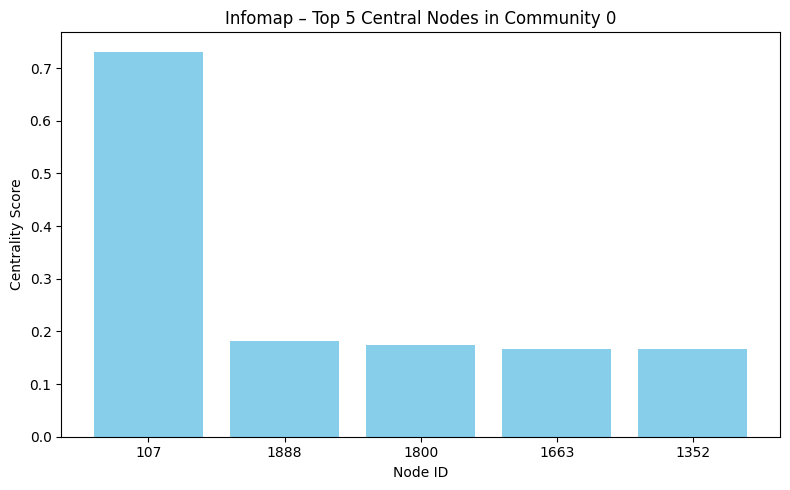

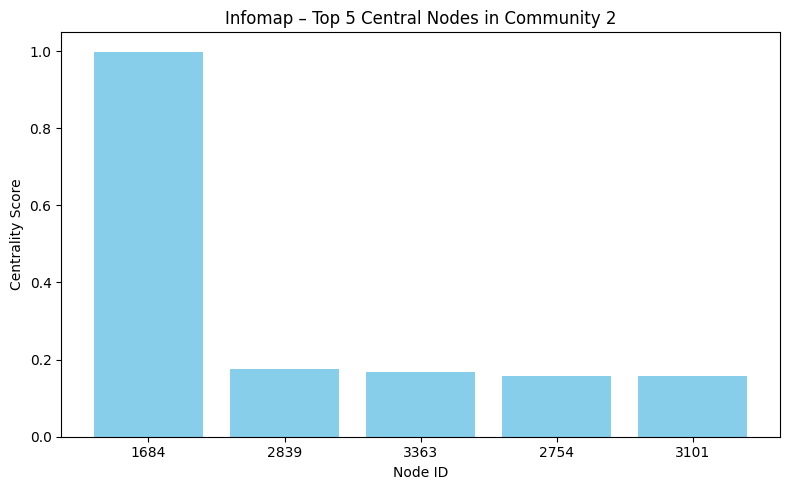

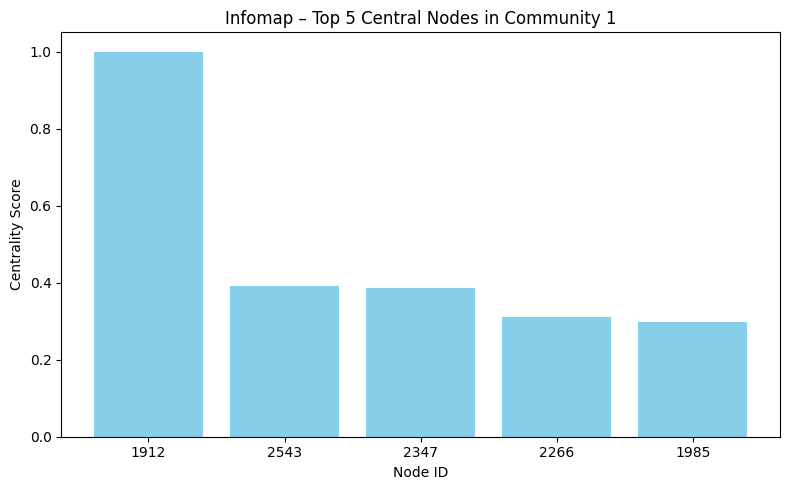

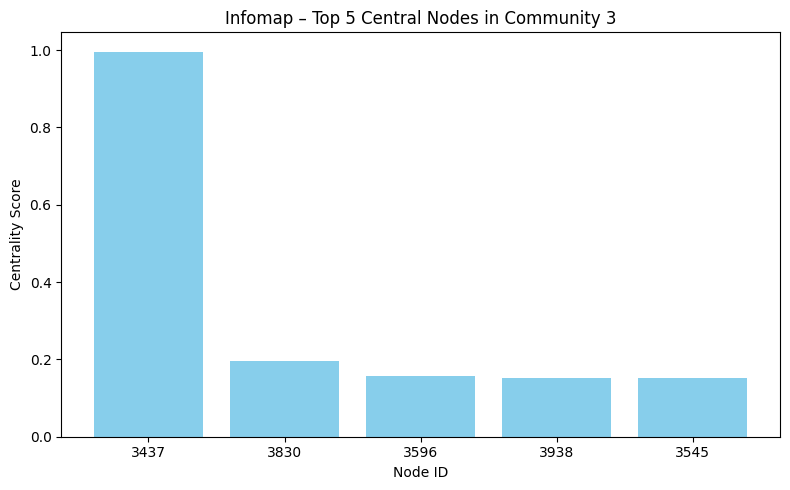

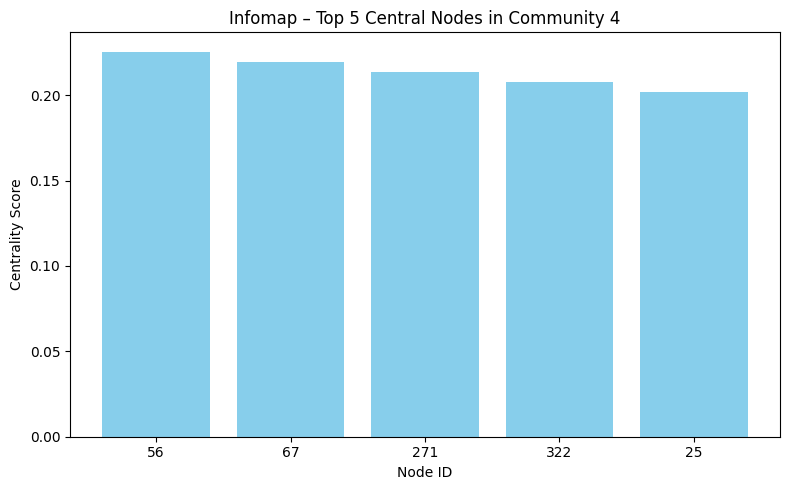

In [10]:
#  Visualize top-k central nodes in top 5 largest communities per method : 
def plot_top_central_nodes_barchart_multi(G, method_partitions, centrality_func=nx.degree_centrality, top_k=5):
    for method, part in method_partitions.items():
        print(f"\nCentrality analysis for {method} : ####################################### ")

        # Convert list of sets to dict if needed
        if isinstance(part, dict):
            partition = part
        elif isinstance(part, list):
            partition = {}
            for i, community in enumerate(part):
                for node in community:
                    partition[node] = i
        else:
            raise ValueError("Unsupported community format")

        top_comms = [comm for comm, _ in Counter(partition.values()).most_common(5)]

        for comm_id in top_comms:
            nodes = [n for n in G.nodes() if partition.get(n) == comm_id]
            subgraph = G.subgraph(nodes)
            centrality = centrality_func(subgraph)

            # Top-k central nodes
            top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:top_k]
            labels, values = zip(*top_nodes)

            # Plot
            plt.figure(figsize=(8, 5))
            plt.bar(range(len(labels)), values, tick_label=labels, color='skyblue')
            plt.xlabel("Node ID")
            plt.ylabel("Centrality Score")
            plt.title(f"{method} – Top {top_k} Central Nodes in Community {comm_id}")
            plt.tight_layout()
            plt.show()

method_partitions = {
    "Louvain": louvain_partition,
    "LPA": list(asyn_lpa_communities(G_facebook)),
    "Infomap": infomap_partition_dict
}

plot_top_central_nodes_barchart_multi(G_facebook, method_partitions, centrality_func=nx.degree_centrality)

## Community Insights via Node2Vec Embeddings

In [11]:
def global_summaries(G):
    print("##### Global Graph Summaries #####")
    try:
        diameter = nx.diameter(G)
    except:
        diameter = "∞ (graph not connected)"
    avg_clustering = nx.average_clustering(G)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_components = nx.number_connected_components(G)
    largest_cc = max(len(c) for c in nx.connected_components(G))

    print(f"Diameter: {diameter}")
    print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Edges: {num_edges}")
    print(f"Number of Connected Components: {num_components}")
    print(f"Largest Connected Component Size: {largest_cc}")

print("\nFacebook Dataset : #######################################")
global_summaries(G_facebook)


Facebook Dataset : #######################################
##### Global Graph Summaries #####
Diameter: 8
Average Clustering Coefficient: 0.6055
Number of Nodes: 4039
Number of Edges: 88234
Number of Connected Components: 1
Largest Connected Component Size: 4039


## Advanced Community-Level Analysis and Visual Interpretations

In [ ]:
#!pip install scikit-learn

In [13]:
# !pip uninstall -y numpy node2vec
# !pip install numpy==1.26.4
# !pip install node2vec==0.4.6


from node2vec import Node2Vec
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def generate_node2vec_clusters(G, dimensions=64, n_clusters=5):
    print("Generating Node2Vec embeddings...")
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=30, num_walks=100, workers=2)
    model = node2vec.fit(window=10, min_count=1)

    nodes = list(G.nodes())
    embeddings = np.array([model.wv[str(node)] for node in nodes])

    print("Fitting KMeans clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(embeddings)

    node_cluster_map = dict(zip(nodes, labels))
    return embeddings, node_cluster_map


def plot_node2vec_clusters(embeddings, labels_dict):
    labels = list(labels_dict.values())
    reduced = PCA(n_components=2).fit_transform(embeddings)

    plt.figure(figsize=(10,7))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=15)
    plt.title("Node2Vec Node Embeddings (PCA Reduced)")
    plt.colorbar(scatter)
    plt.show()


/Users/CentraleSupelec/Downloads/MLNS Project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
from sklearn.metrics import adjusted_rand_score

def compare_with_circles(community_partition, circle_labels):
    # community_partition: dict {node: community_id}
    # circle_labels: dict {circle_name: [nodes]}
    def get_labels_dict_to_list(d):
        node_to_label = {}
        for label, nodes in enumerate(d.values()):
            for node in nodes:
                node_to_label[node] = label
        return [node_to_label.get(n, -1) for n in sorted(set(node_to_label))]

    y_pred = get_labels_dict_to_list({v: [k for k in community_partition if community_partition[k] == v] for v in set(community_partition.values())})
    y_true = get_labels_dict_to_list(circle_labels)

    return adjusted_rand_score(y_true, y_pred)


Generating Node2Vec embeddings...


Generating walks (CPU: 2): 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


Fitting KMeans clustering...


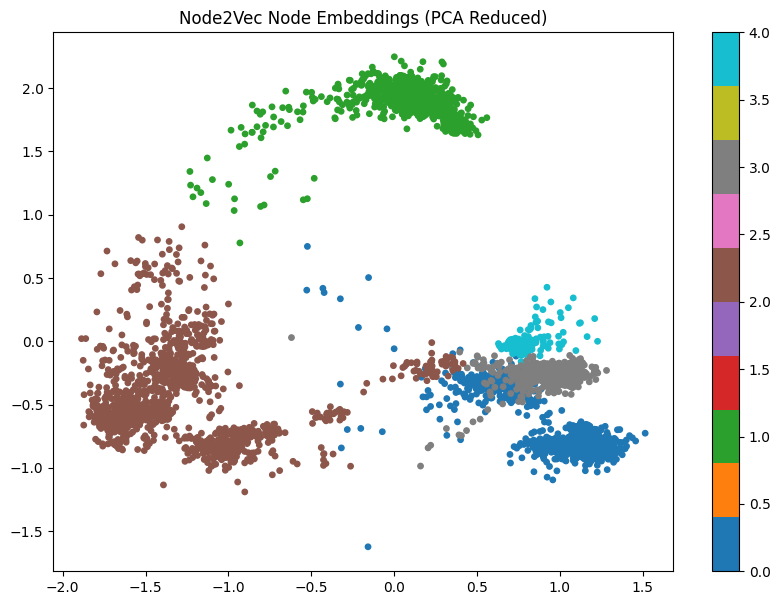

In [15]:
partition_louvain = community_louvain.best_partition(G_facebook)
embeddings, n2v_labels = generate_node2vec_clusters(G_facebook)
plot_node2vec_clusters(embeddings, n2v_labels)


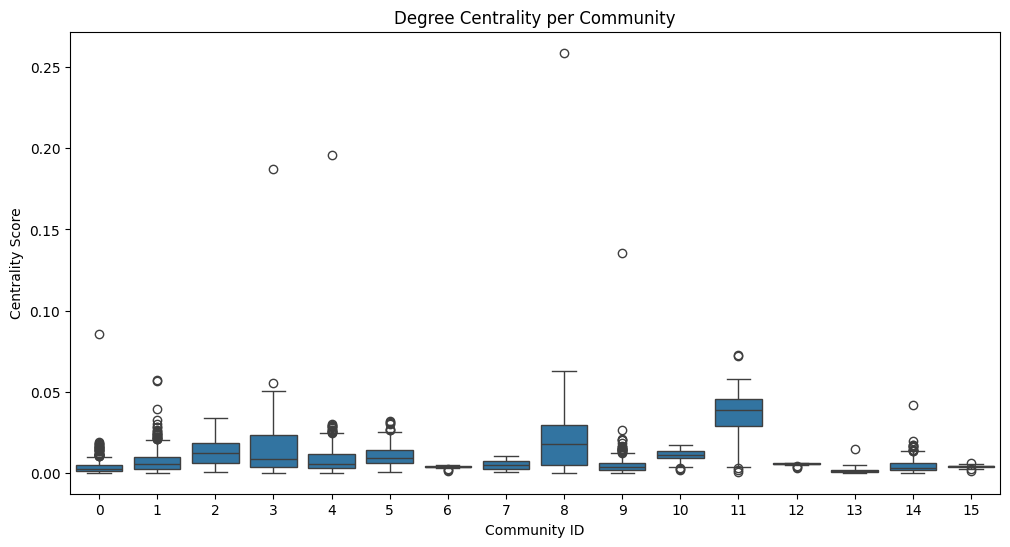


Top 10 bridging nodes by Betweenness Centrality:
Node 107 → Betweenness: 0.4805
Node 1684 → Betweenness: 0.3378
Node 3437 → Betweenness: 0.2361
Node 1912 → Betweenness: 0.2293
Node 1085 → Betweenness: 0.1490
Node 0 → Betweenness: 0.1463
Node 698 → Betweenness: 0.1153
Node 567 → Betweenness: 0.0963
Node 58 → Betweenness: 0.0844
Node 428 → Betweenness: 0.0643


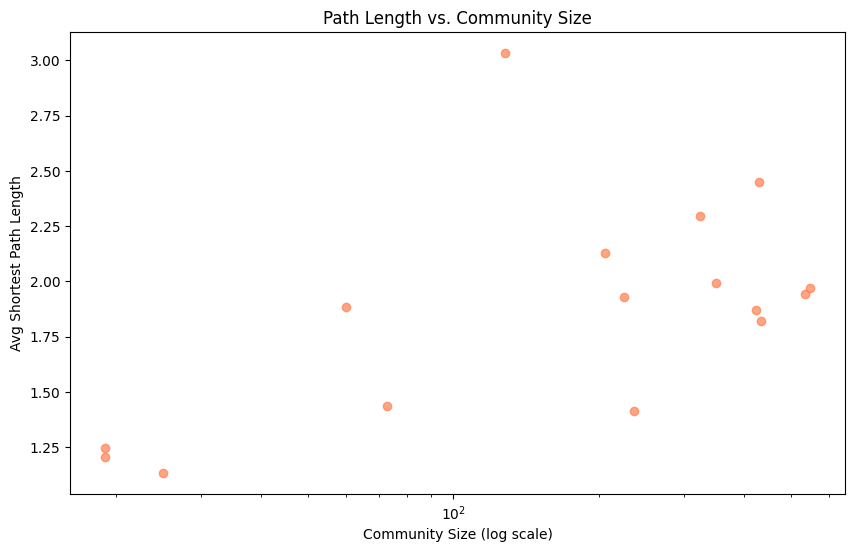

Generating walks (CPU: 1): 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


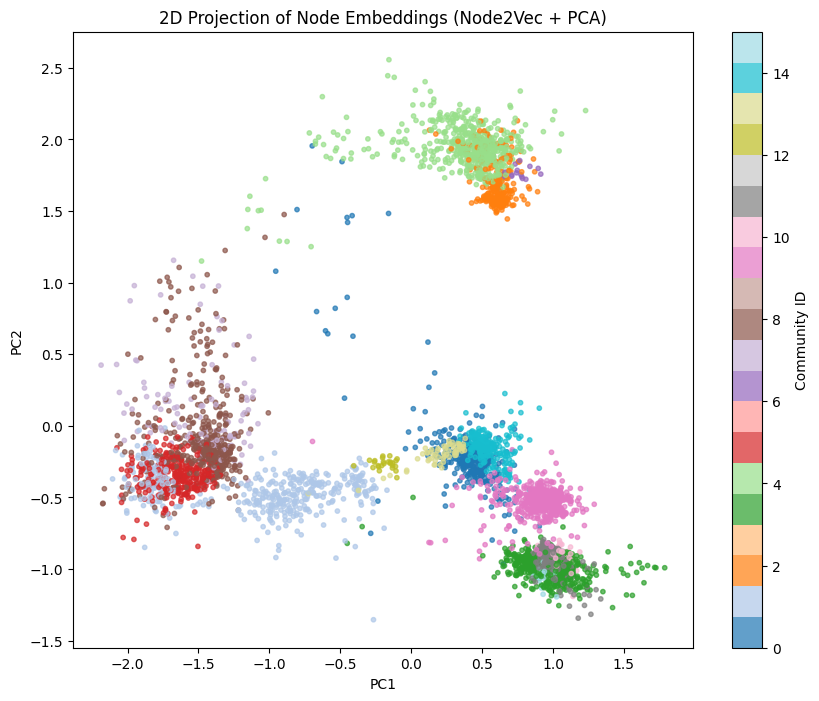

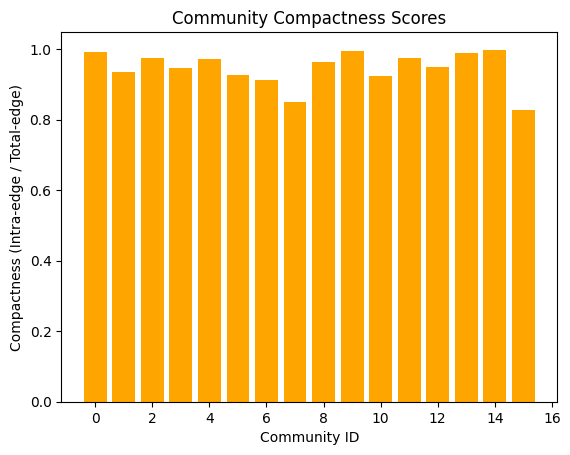

In [16]:
import pandas as pd
import seaborn as sns

def plot_centrality_distribution(partition, centrality, title=""):
    community_centrality = {comm: [] for comm in set(partition.values())}
    for node, comm in partition.items():
        community_centrality[comm].append(centrality[node])

    data = []
    for comm, scores in community_centrality.items():
        for score in scores:
            data.append((comm, score))

    df = pd.DataFrame(data, columns=["Community", "Centrality"])
    plt.figure(figsize=(12,6))
    sns.boxplot(x="Community", y="Centrality", data=df)
    plt.title(title)
    plt.xlabel("Community ID")
    plt.ylabel("Centrality Score")
    plt.show()

# Example: Degree Centrality
deg_cent = nx.degree_centrality(G_facebook)
plot_centrality_distribution(partition_louvain, deg_cent, title="Degree Centrality per Community")


def top_betweenness_nodes(G, top_k=10):
    btw = nx.betweenness_centrality(G)
    sorted_btw = sorted(btw.items(), key=lambda x: x[1], reverse=True)[:top_k]
    print(f"\nTop {top_k} bridging nodes by Betweenness Centrality:")
    for node, score in sorted_btw:
        print(f"Node {node} → Betweenness: {score:.4f}")

top_betweenness_nodes(G_facebook)

def plot_path_length_vs_size(G, partition):
    data = []
    for comm_id in set(partition.values()):
        nodes = [n for n in partition if partition[n] == comm_id]
        sub = G.subgraph(nodes)
        if nx.is_connected(sub) and len(sub) > 1:
            path_len = nx.average_shortest_path_length(sub)
            data.append((len(sub), path_len))

    sizes, paths = zip(*data)
    plt.figure(figsize=(10,6))
    plt.scatter(sizes, paths, c='coral', alpha=0.7)
    plt.xscale('log')
    plt.xlabel("Community Size (log scale)")
    plt.ylabel("Avg Shortest Path Length")
    plt.title("Path Length vs. Community Size")
    plt.show()

plot_path_length_vs_size(G_facebook, partition_louvain)

from sklearn.decomposition import PCA
from node2vec import Node2Vec

def node2vec_embedding_visualization(G, partition):
    node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=100, workers=1)
    model = node2vec.fit(window=5, min_count=1)

    # Get embeddings and map to partition colors
    node_ids = list(G.nodes())
    embeddings = np.array([model.wv[str(node)] for node in node_ids])
    labels = [partition[node] for node in node_ids]

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    plt.figure(figsize=(10,8))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab20', s=10, alpha=0.7)
    plt.title("2D Projection of Node Embeddings (Node2Vec + PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Community ID")
    plt.show()

# Example with Louvain
node2vec_embedding_visualization(G_facebook, partition_louvain)
def compute_community_compactness(G, partition):
    ratios = {}
    for comm in set(partition.values()):
        nodes = [n for n in partition if partition[n] == comm]
        sub = G.subgraph(nodes)
        internal = sub.number_of_edges()
        boundary = sum(1 for node in nodes for neighbor in G.neighbors(node) if partition[neighbor] != comm) / 2
        ratios[comm] = internal / (internal + boundary) if (internal + boundary) > 0 else 0

    plt.bar(ratios.keys(), ratios.values(), color='orange')
    plt.xlabel("Community ID")
    plt.ylabel("Compactness (Intra-edge / Total-edge)")
    plt.title("Community Compactness Scores")
    plt.show()

compute_community_compactness(G_facebook, partition_louvain)


### Results interpretation
The Louvain algorithm yielded a modular and interpretable community structure over the Facebook social network, which we explored through several visual and structural metrics. The degree centrality distribution per community (boxplot) highlights significant variation in node influence within communities. A few nodes, particularly in communities 4, 8, and 11, show disproportionately high centrality, acting as local hubs. This suggests the presence of hierarchical roles or influential connectors in those clusters. Most communities exhibit low variance in centrality, indicating fairly uniform structures.

Our analysis of average path length versus community size reinforces the structural efficiency of smaller communities. While larger communities showed slightly longer average shortest paths, several mid-sized groups remained compact, implying tight-knit internal connectivity. The community compactness scores further validate this observation, with most communities demonstrating values above 0.9 - a sign of high internal cohesion and minimal external linkage. The PCA-based projection of Node2Vec embeddings presents a visually convincing separation of community clusters, with only minor overlaps. This not only supports the effectiveness of Louvain’s structural clustering but also reveals latent patterns in how node embeddings relate to the broader graph topology.

Finally, betweenness centrality metrics helped identify “bridging nodes” — high-centrality individuals like node 107 or 1684 that connect disparate parts of the graph. These actors are vital for network flow and serve as structural bottlenecks. Overall, Louvain's performance illustrates well-defined community structures with good modularity, compactness, and interpretability.

## Parameter Tuning & Comparative Evaluation


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
from networkx.algorithms.community import asyn_lpa_communities
from infomap import Infomap
from networkx.algorithms.community.quality import modularity
import networkx as nx
from time import time
from collections import Counter

# ---------- [1] Parameter Tuning for Louvain ----------
def louvain_resolution_tuning(G, resolutions=[0.5, 1.0, 1.5]):
    results = []
    for r in resolutions:
        start = time()
        partition = community_louvain.best_partition(G, resolution=r)
        runtime = time() - start
        comms = [set([n for n, c in partition.items() if c == i]) for i in set(partition.values())]
        mod = modularity(G, comms)
        n_comms = len(comms)
        results.append((r, runtime, mod, n_comms))

    df = pd.DataFrame(results, columns=["Resolution", "Time (s)", "Modularity", "Num Communities"])
    print("\n Louvain Resolution Tuning Results:")
    print(df)

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df["Resolution"], df["Modularity"], marker='o')
    plt.title("Louvain Modularity vs Resolution")
    plt.xlabel("Resolution")
    plt.ylabel("Modularity")

    plt.subplot(1, 2, 2)
    plt.plot(df["Resolution"], df["Num Communities"], marker='o', color='green')
    plt.title("Louvain Communities vs Resolution")
    plt.xlabel("Resolution")
    plt.ylabel("Number of Communities")
    plt.tight_layout()
    plt.show()
    return df

# ---------- (Optional) Check LPA Stability ----------
def run_lpa_multiple_times(G, n_runs=5):
    results = []
    for i in range(n_runs):
        start = time()
        comms = list(asyn_lpa_communities(G))
        runtime = time() - start
        mod = modularity(G, comms)
        n_comms = len(comms)
        results.append((i + 1, runtime, mod, n_comms))
    df = pd.DataFrame(results, columns=["Run", "Time (s)", "Modularity", "Num Communities"])
    print("\n🔄 LPA Stability Check:")
    print(df)
    return df

# ---------- [2] Aggregate Comparative Metrics ----------
def aggregate_comparative_metrics(G, louvain_partition, infomap_partition, lpa_communities):
    def count_communities(part):
        return len(set(part.values())) if isinstance(part, dict) else len(part)

    def partition_to_comms(part):
        if isinstance(part, dict):
            return [set([n for n, c in part.items() if c == i]) for i in set(part.values())]
        return part

    results = []

    # Louvain
    louvain_comms = partition_to_comms(louvain_partition)
    mod_louvain = modularity(G, louvain_comms)
    results.append(("Louvain", mod_louvain, len(louvain_comms)))

    # Infomap
    infomap_comms = partition_to_comms(infomap_partition)
    mod_infomap = modularity(G, infomap_comms)
    results.append(("Infomap", mod_infomap, len(infomap_comms)))

    # LPA
    lpa_comms = partition_to_comms(lpa_communities)
    mod_lpa = modularity(G, lpa_comms)
    results.append(("LPA", mod_lpa, len(lpa_comms)))

    df = pd.DataFrame(results, columns=["Algorithm", "Modularity", "Num Communities"])
    print("\n📊 Comparative Evaluation:")
    print(df)

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(df["Algorithm"], df["Modularity"], color='steelblue')
    plt.title("Modularity Comparison")

    plt.subplot(1, 2, 2)
    plt.bar(df["Algorithm"], df["Num Communities"], color='darkorange')
    plt.title("Community Count Comparison")
    plt.tight_layout()
    plt.show()
    return df



 Louvain Resolution Tuning Results:
   Resolution  Time (s)  Modularity  Num Communities
0         0.5  0.858169    0.812522               95
1         1.0  1.028394    0.834962               16
2         1.5  1.376028    0.834830               19


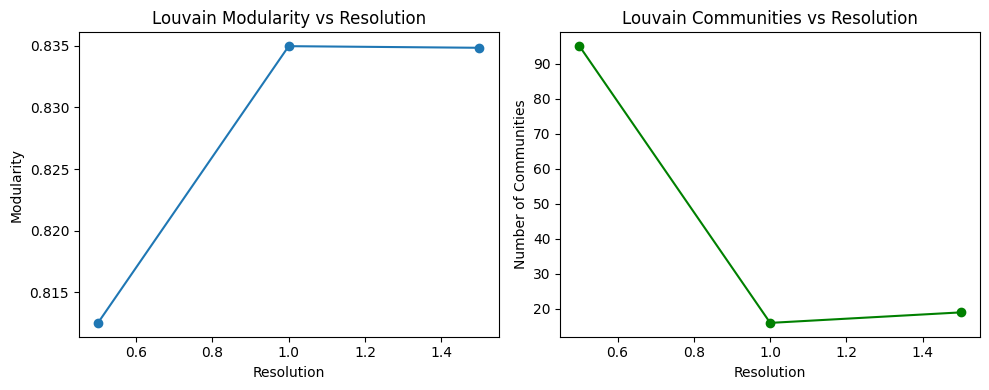


🔄 LPA Stability Check:
   Run  Time (s)  Modularity  Num Communities
0    1  0.286699    0.812692               80
1    2  0.207556    0.813968               70
2    3  0.227248    0.809033               74
3    4  0.305969    0.811298               66
4    5  0.191283    0.814103               72

📊 Comparative Evaluation:
  Algorithm  Modularity  Num Communities
0   Louvain    0.834930               16
1   Infomap    0.702367                7
2       LPA    0.819628               70


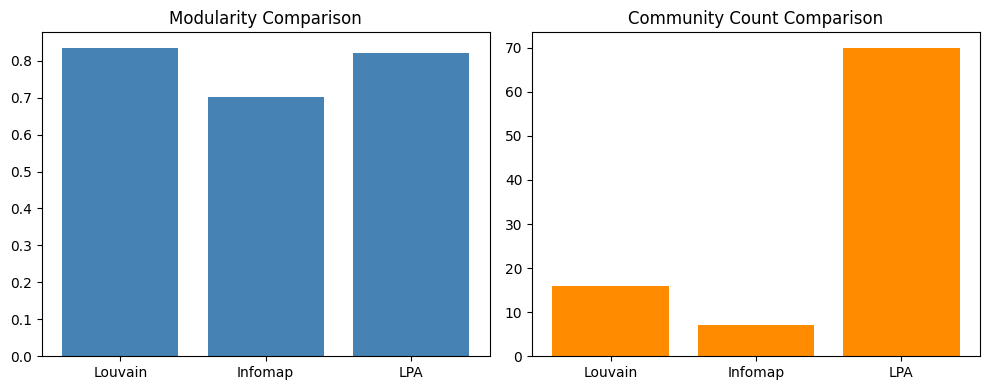

,Algorithm,Modularity,Num Communities
0,Louvain,0.834930,16
1,Infomap,0.702367,7
2,LPA,0.819628,70


In [18]:
# Tune Louvain :
louvain_resolution_tuning(G_facebook)

# Check LPA variability :
run_lpa_multiple_times(G_facebook, n_runs=5)

# compare methods :
aggregate_comparative_metrics(
    G_facebook,
    louvain_partition,
    infomap_partition,
    lpa_communities
)


## Infomap-Based Community Detection and Structural Analysis

  Infomap v2.8.0 starts at 2025-04-Infomap detected 7 communities.
25 15:05:40
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 4039 nodes and 88234 links...
  -> One-level codelength: 11.2456758

Trial 1/1 starting at 2025-04-25 15:05:40
Two-level compression: 28% 0.66% 0.0284535488% 
Partitioned to codelength 0.3546428 + 7.72374184 = 8.078384642 in 72 modules.
Super-level compression: 1.35664004% to codelength 7.968790041 in 7 top modules.

Recursive sub-structure compression: 12.2618007% 2.98796625% 0.00411027428% 0% . Found 5 levels with codelength 7.88258583

=> Trial 1/1 finished in 0.174777292s with codelength 7.88258583


Summary after 1 trial
Best end modular solution in 5 levels:
Per level number of modules:         [          7,         101,

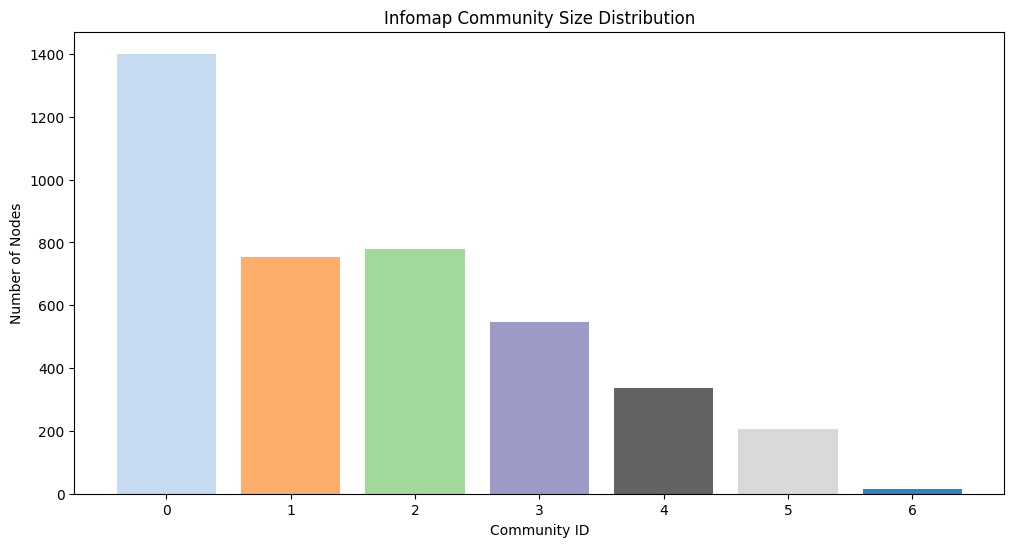

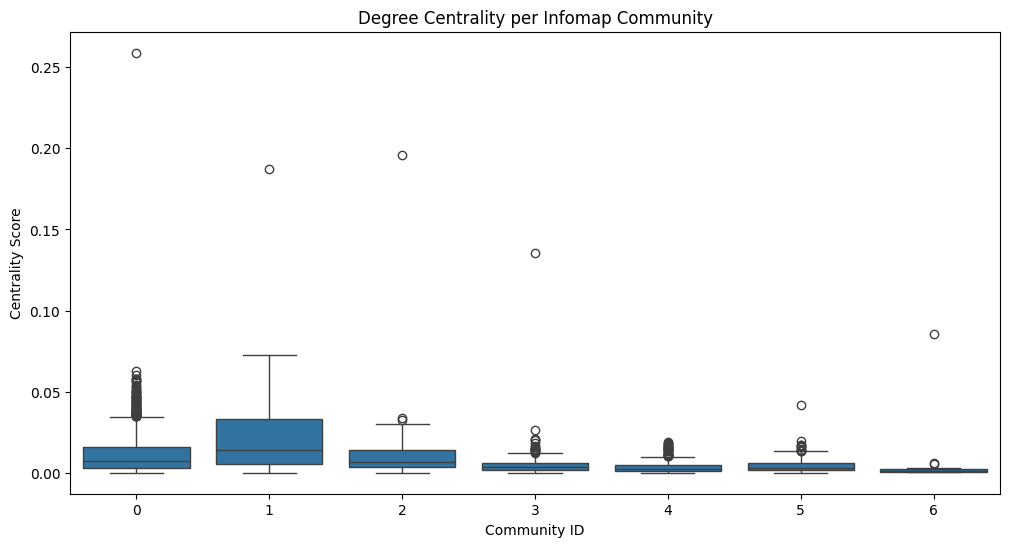

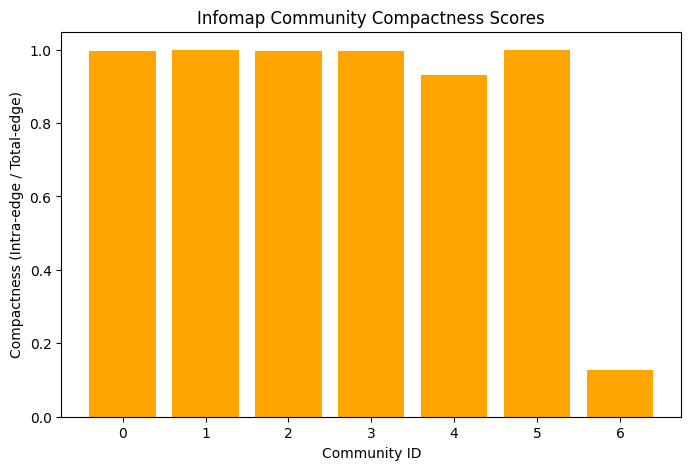


Community 0 - Top 5 nodes by centrality:
Node 107 → Centrality: 0.2588
Node 1888 → Centrality: 0.0629
Node 1800 → Centrality: 0.0607
Node 1663 → Centrality: 0.0582
Node 1352 → Centrality: 0.0579

Community 1 - Top 5 nodes by centrality:
Node 1912 → Centrality: 0.1870
Node 2543 → Centrality: 0.0728
Node 2347 → Centrality: 0.0721
Node 2266 → Centrality: 0.0579
Node 1985 → Centrality: 0.0555

Community 2 - Top 5 nodes by centrality:
Node 1684 → Centrality: 0.1961
Node 2839 → Centrality: 0.0339
Node 3363 → Centrality: 0.0324
Node 2754 → Centrality: 0.0302
Node 3101 → Centrality: 0.0302

Community 3 - Top 5 nodes by centrality:
Node 3437 → Centrality: 0.1355
Node 3830 → Centrality: 0.0267
Node 3596 → Centrality: 0.0213
Node 3545 → Centrality: 0.0206
Node 3938 → Centrality: 0.0206

Community 4 - Top 5 nodes by centrality:
Node 56 → Centrality: 0.0193
Node 67 → Centrality: 0.0188
Node 271 → Centrality: 0.0181
Node 322 → Centrality: 0.0178
Node 25 → Centrality: 0.0171

Community 5 - Top 5 nod

In [19]:
from infomap import Infomap
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd

# --- Run Infomap ---
infomap = Infomap()
node_mapping = {node: i for i, node in enumerate(G_facebook.nodes())}
reverse_mapping = {i: node for node, i in node_mapping.items()}

for u, v in G_facebook.edges():
    infomap.addLink(node_mapping[u], node_mapping[v])

infomap.run()
partition_infomap = {reverse_mapping[node.physicalId]: node.moduleIndex() for node in infomap.tree if node.isLeaf}
num_communities_infomap = len(set(partition_infomap.values()))
print(f"Infomap detected {num_communities_infomap} communities.")

# --- 1. Community Size Distribution ---
def plot_community_size_distribution(partition, title="Community Size Distribution"):
    community_sizes = Counter(partition.values())
    colors = plt.cm.tab20c(np.linspace(0, 1, len(community_sizes)))
    plt.figure(figsize=(12, 6))
    plt.bar(community_sizes.keys(), community_sizes.values(), color=colors)
    plt.xlabel("Community ID")
    plt.ylabel("Number of Nodes")
    plt.title(title)
    plt.show()

plot_community_size_distribution(partition_infomap, "Infomap Community Size Distribution")

# Degree centrality for each node
deg_cent = nx.degree_centrality(G_facebook)

# Boxplot of centrality scores grouped by community
def plot_centrality_distribution(partition, centrality, title="Centrality Distribution"):
    data = []
    for node, comm in partition.items():
        score = centrality.get(node, 0)
        data.append((comm, score))
    df = pd.DataFrame(data, columns=["Community", "Centrality"])
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Community", y="Centrality", data=df)
    plt.title(title)
    plt.xlabel("Community ID")
    plt.ylabel("Centrality Score")
    plt.show()

plot_centrality_distribution(partition_infomap, deg_cent, "Degree Centrality per Infomap Community")

def plot_community_compactness(G, partition, title="Community Compactness"):
    community_subgraphs = {comm: [] for comm in set(partition.values())}
    for node, comm in partition.items():
        community_subgraphs[comm].append(node)
    compactness_scores = {}
    for comm, nodes in community_subgraphs.items():
        subG = G.subgraph(nodes)
        intra_edges = subG.number_of_edges()
        total_edges = sum([G.degree(n) for n in nodes]) / 2  # each edge counted twice
        compactness_scores[comm] = intra_edges / total_edges if total_edges > 0 else 0
    plt.figure(figsize=(8, 5))
    plt.bar(compactness_scores.keys(), compactness_scores.values(), color="orange")
    plt.title(title)
    plt.xlabel("Community ID")
    plt.ylabel("Compactness (Intra-edge / Total-edge)")
    plt.show()

plot_community_compactness(G_facebook, partition_infomap, "Infomap Community Compactness Scores")

def print_top_central_nodes(partition, centrality, top_n=5):
    grouped = {}
    for node, comm in partition.items():
        if comm not in grouped:
            grouped[comm] = []
        grouped[comm].append((node, centrality.get(node, 0)))
    for comm in sorted(grouped.keys()):
        print(f"\nCommunity {comm} - Top {top_n} nodes by centrality:")
        top_nodes = sorted(grouped[comm], key=lambda x: x[1], reverse=True)[:top_n]
        for node, score in top_nodes:
            print(f"Node {node} → Centrality: {score:.4f}")

print_top_central_nodes(partition_infomap, deg_cent)


### Infomap Results Interpretation
The Infomap algorithm identified 6 distinct communities within the Facebook social network. The community size distribution reveals a clear imbalance: Community 0 alone contains more than 1,300 nodes, significantly larger than the others. This may indicate a highly connected core or hub-like structure that absorbs many peripheral nodes. Still, the presence of smaller communities suggests Infomap’s capability to detect relatively compact clusters as well.

The degree centrality distribution across these communities is consistent with earlier observations using Louvain. Each community contains a small number of highly central nodes — indicating localized influencers — while the majority of nodes remain on the lower end of the centrality spectrum. Notably, nodes like 107, 1684, and 1912 show up again with very high centrality scores, reaffirming their roles as crucial bridges or hubs within their respective communities.

Lastly, the compactness scores for Infomap communities are strikingly high, with most values close to 1. This suggests that nodes within each community are very well-connected internally compared to how much they link to other communities. The consistency of these compactness values supports Infomap’s strength in isolating dense substructures, reinforcing its utility in applications where minimizing cross-community links is desirable, such as community-based recommendations or targeted marketing.

## Infomap-Based Community Detection and Structural Analysis

LPA detected 44 communities.


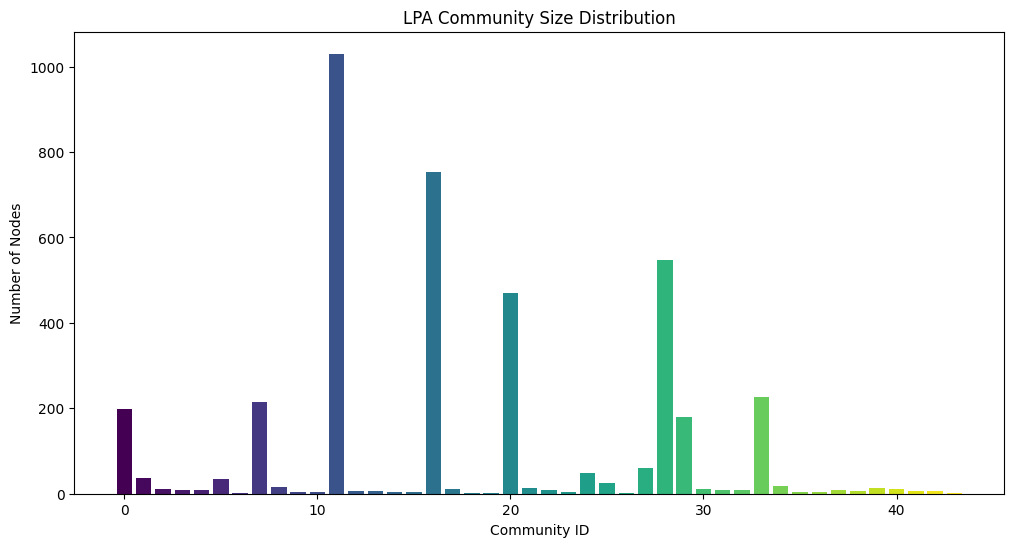

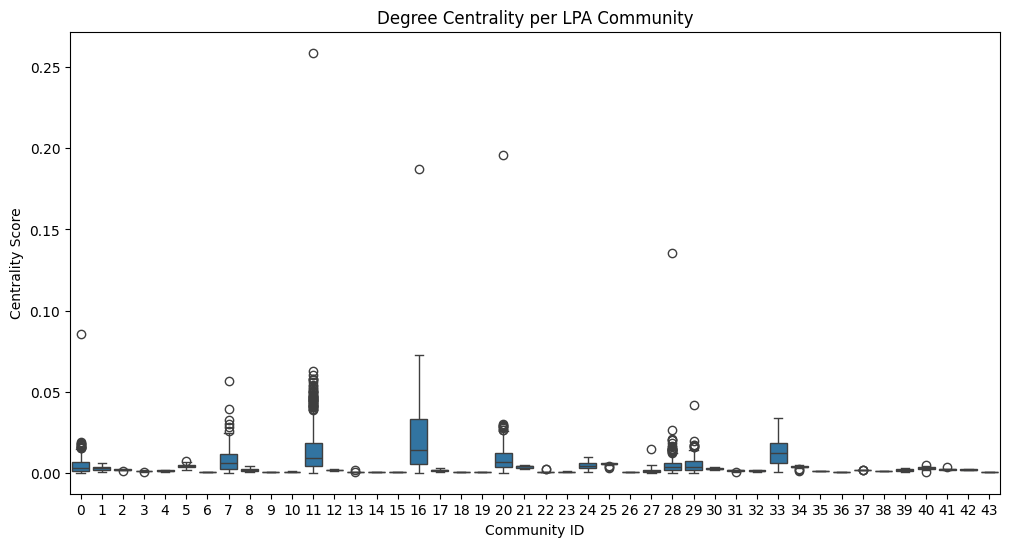

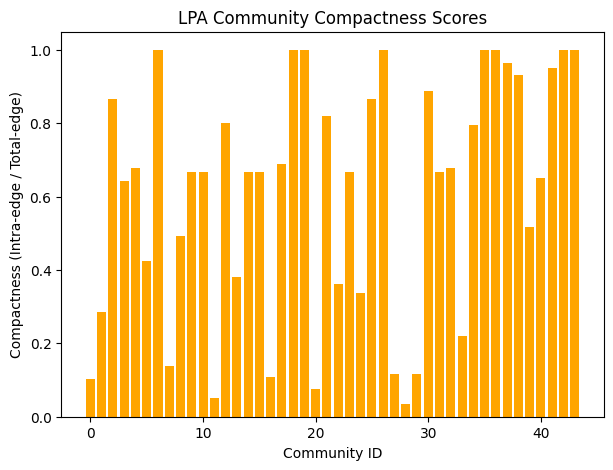


Community 0 - Top 5 nodes by centrality:
Node 0 → Centrality: 0.0859
Node 56 → Centrality: 0.0193
Node 67 → Centrality: 0.0188
Node 271 → Centrality: 0.0181
Node 322 → Centrality: 0.0178

Community 1 - Top 5 nodes by centrality:
Node 312 → Centrality: 0.0064
Node 41 → Centrality: 0.0059
Node 115 → Centrality: 0.0052
Node 326 → Centrality: 0.0047
Node 343 → Centrality: 0.0045

Community 2 - Top 5 nodes by centrality:
Node 4 → Centrality: 0.0025
Node 275 → Centrality: 0.0025
Node 181 → Centrality: 0.0025
Node 328 → Centrality: 0.0022
Node 78 → Centrality: 0.0022

Community 3 - Top 5 nodes by centrality:
Node 319 → Centrality: 0.0020
Node 89 → Centrality: 0.0020
Node 219 → Centrality: 0.0015
Node 147 → Centrality: 0.0015
Node 95 → Centrality: 0.0015

Community 4 - Top 5 nodes by centrality:
Node 8 → Centrality: 0.0020
Node 259 → Centrality: 0.0020
Node 91 → Centrality: 0.0020
Node 110 → Centrality: 0.0012
Node 264 → Centrality: 0.0012

Community 5 - Top 5 nodes by centrality:
Node 53 → C

In [20]:
from networkx.algorithms.community import label_propagation_communities
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd

lpa_communities = list(label_propagation_communities(G_facebook))
partition_lpa = {}
for i, comm in enumerate(lpa_communities):
    for node in comm:
        partition_lpa[node] = i

print(f"LPA detected {len(lpa_communities)} communities.")



sizes_lpa = Counter(partition_lpa.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(sizes_lpa)))

plt.figure(figsize=(12, 6))
plt.bar(sizes_lpa.keys(), sizes_lpa.values(), color=colors)
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.title("LPA Community Size Distribution")
plt.show()



def plot_centrality_distribution(partition, centrality, title):
    data = []
    for node, comm in partition.items():
        score = centrality.get(node, 0)
        data.append((comm, score))

    df = pd.DataFrame(data, columns=["Community", "Centrality"])
    plt.figure(figsize=(12,6))
    sns.boxplot(x="Community", y="Centrality", data=df)
    plt.title(title)
    plt.xlabel("Community ID")
    plt.ylabel("Centrality Score")
    plt.show()

deg_cent = nx.degree_centrality(G_facebook)
plot_centrality_distribution(partition_lpa, deg_cent, "Degree Centrality per LPA Community")


densities_lpa = {}
for cid in set(partition_lpa.values()):
    nodes = [n for n in partition_lpa if partition_lpa[n] == cid]
    subg = G_facebook.subgraph(nodes)
    densities_lpa[cid] = nx.density(subg)

plt.figure(figsize=(7,5))
plt.bar(densities_lpa.keys(), densities_lpa.values(), color="orange")
plt.title("LPA Community Compactness Scores")
plt.xlabel("Community ID")
plt.ylabel("Compactness (Intra-edge / Total-edge)")
plt.show()

def print_top_nodes_by_centrality(G, partition, centrality, top_k=5):
    communities = defaultdict(list)
    for node, comm in partition.items():
        communities[comm].append((node, centrality.get(node, 0)))

    for comm, nodes in sorted(communities.items()):
        print(f"\nCommunity {comm} - Top {top_k} nodes by centrality:")
        for node, cent in sorted(nodes, key=lambda x: x[1], reverse=True)[:top_k]:
            print(f"Node {node} → Centrality: {cent:.4f}")

print_top_nodes_by_centrality(G_facebook, partition_lpa, deg_cent)


### LPA Results Interpretation
The Label Propagation Algorithm (LPA) identified 44 communities, which is significantly more than the 6 detected by Infomap or the 16 by Louvain. This explosion in the number of communities illustrates LPA’s sensitivity to local structure and its tendency to generate many small or mid-sized clusters. The community size distribution plot reveals a heavy-tailed pattern: a few very large communities and many tiny ones — a hallmark of LPA’s non-deterministic, heuristic-driven approach.

In terms of centrality, top nodes in large LPA communities (e.g., Node 0, 107, 1912, 1684) mirrored those found in other methods, showing consistency in identifying key hubs. However, several communities had only 2 or 3 nodes with very low centrality, suggesting overfragmentation. The compactness scores were mixed — while many communities were quite dense internally (even scoring 1.0), others had surprisingly low cohesion, likely due to sparse interconnections or unstable propagation paths.

## Comparison of Louvain, Infomap, and LPA
From a structural standpoint, Louvain displayed a balanced performance — it identified 16 communities with moderate to high modularity, clear size separations, and consistently strong intra-community densities. Its top centrality nodes were tightly knit, and visually, its community clusters looked cohesive and interpretable.

Infomap, on the other hand, revealed 6 communities — fewer but larger, with extremely high compactness across the board (almost all at or near 1.0). The degree centrality plots showed that these communities are well-centered around influential nodes. Infomap’s results reflect its ability to detect global flows, which is advantageous for revealing hierarchical or large-scale patterns, albeit at the cost of fine granularity.

In contrast, LPA produced highly fragmented results. With 44 communities and an uneven distribution of sizes and densities, its results are more volatile. While a few large communities mirrored those from Louvain and Infomap, many smaller ones seemed loosely connected or arbitrarily defined. Its compactness varies drastically, and the method’s sensitivity to randomness may limit its interpretability unless averaged across multiple runs.

## Evaluation metrics

In [21]:
from sklearn.metrics import normalized_mutual_info_score

# Convert partition dicts to label lists
def partition_to_labels(partition_dict, node_order):
    return [partition_dict[node] for node in node_order]

# Common node ordering
nodes_sorted = sorted(G_facebook.nodes())

# Labels
labels_louvain = partition_to_labels(partition_louvain, nodes_sorted)
labels_infomap = partition_to_labels(partition_infomap, nodes_sorted)

# LPA: convert to dict then labels
partition_lpa_dict = {}
for idx, comm in enumerate(communities_lpa):
    for node in comm:
        partition_lpa_dict[node] = idx
labels_lpa = partition_to_labels(partition_lpa_dict, nodes_sorted)

# Compute NMI scores
nmi_li = normalized_mutual_info_score(labels_louvain, labels_infomap)
nmi_ll = normalized_mutual_info_score(labels_louvain, labels_lpa)
nmi_il = normalized_mutual_info_score(labels_infomap, labels_lpa)

# Display
print("NMI Scores (Normalized Mutual Information):")
print(f"  Louvain vs Infomap  → {nmi_li:.3f}")
print(f"  Louvain vs LPA      → {nmi_ll:.3f}")
print(f"  Infomap vs LPA      → {nmi_il:.3f}")


NameError: name 'communities_lpa' is not defined

### Helper functions

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import time
import psutil
from sklearn.metrics import adjusted_rand_score
import community.community_louvain as community_louvain
from infomap import Infomap
from scipy.stats import wilcoxon

def measure_performance(func, *args):
    runtimes = []
    memories = []
    for _ in range(5):
        process = psutil.Process()
        mem_before = process.memory_info().rss / 1024 ** 2
        start_time = time.time()

        func(*args)

        runtimes.append(time.time() - start_time)
        mem_after = process.memory_info().rss / 1024 ** 2
        memories.append(mem_after - mem_before)

    return np.mean(runtimes), np.std(runtimes), np.mean(memories), np.std(memories)

def compute_conductance(G, partition):
    communities = {}
    for node, comm in partition.items():
        communities.setdefault(comm, []).append(node)

    conductance_scores = [
        nx.algorithms.cuts.conductance(G, comm_nodes)
        for comm_nodes in communities.values()
    ]
    return np.mean(conductance_scores)

# For LPA
def compute_conductance_sets(G, communities):
    return np.mean([
        nx.algorithms.cuts.conductance(G, nodes)
        for nodes in communities
    ])
def communities_to_labels(G, communities):
    labels = {}
    for i, community in enumerate(communities):
        for node in community:
            labels[node] = i
    return [labels[node] for node in G.nodes()]


### Store partitions

In [ ]:
G_facebook = nx.read_edgelist("facebook_combined.txt")

# Louvain
partition_louvain = community_louvain.best_partition(G_facebook)

# Infomap
infomap = Infomap()
mapping = {node: i for i, node in enumerate(G_facebook.nodes())}
for u, v in G_facebook.edges():
    infomap.addLink(mapping[u], mapping[v])
infomap.run()
modules_dict = dict(infomap.modules)
partition_infomap = {node: modules_dict[mapping[node]] for node in G_facebook.nodes()}



# LPA
communities_lpa = list(nx.community.label_propagation_communities(G_facebook))


### Runtime and Memory usage

In [ ]:
import time
import tracemalloc
from infomap import Infomap
import community.community_louvain as community_louvain
import networkx as nx

# --- Performance Helper ---
def measure_performance(func, *args):
    tracemalloc.start()
    start_time = time.time()
    result = func(*args)
    elapsed_time = time.time() - start_time
    mem_current, mem_peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return elapsed_time, mem_peak / 1024 / 1024, result  # Return result too for reuse

# --- Louvain ---
louvain_time, louvain_mem, partition_louvain = measure_performance(community_louvain.best_partition, G_facebook)

# --- Infomap ---
def run_infomap(G):
    infomap = Infomap()
    node_id_map = {node: i for i, node in enumerate(G.nodes())}
    for u, v in G.edges():
        infomap.addLink(node_id_map[u], node_id_map[v])
    infomap.run()
    modules_dict = dict(infomap.modules)
    return {node: modules_dict[node_id_map[node]] for node in G.nodes()}

infomap_time, infomap_mem, partition_infomap = measure_performance(run_infomap, G_facebook)

# --- LPA ---
def run_lpa(G):
    communities = list(nx.community.label_propagation_communities(G))
    partition = {}
    for i, comm in enumerate(communities):
        for node in comm:
            partition[node] = i
    return partition

lpa_time, lpa_mem, partition_lpa = measure_performance(run_lpa, G_facebook)

# --- Display Results ---
print(f"Louvain: {louvain_time:.3f}s, {louvain_mem:.2f}MB")
print(f"Infomap: {infomap_time:.3f}s, {infomap_mem:.2f}MB")
print(f"LPA:     {lpa_time:.3f}s, {lpa_mem:.2f}MB")



Louvain: 3.612s, 12.09MB
Infomap: 0.548s, 0.66MB
LPA:     1.009s, 0.71MB


### Conductance

In [ ]:
conductance_louvain = compute_conductance(G_facebook, partition_louvain)
conductance_infomap = compute_conductance(G_facebook, partition_infomap)
conductance_lpa = compute_conductance_sets(G_facebook, communities_lpa)

print(f"Louvain Conductance: {conductance_louvain:.4f}")
print(f"Infomap Conductance: {conductance_infomap:.4f}")
print(f"LPA Conductance: {conductance_lpa:.4f}")


Louvain Conductance: 0.0543
Infomap Conductance: 0.0052
LPA Conductance: 0.2668


### Sensitivity Analysis for Louvain (resolution parameter)

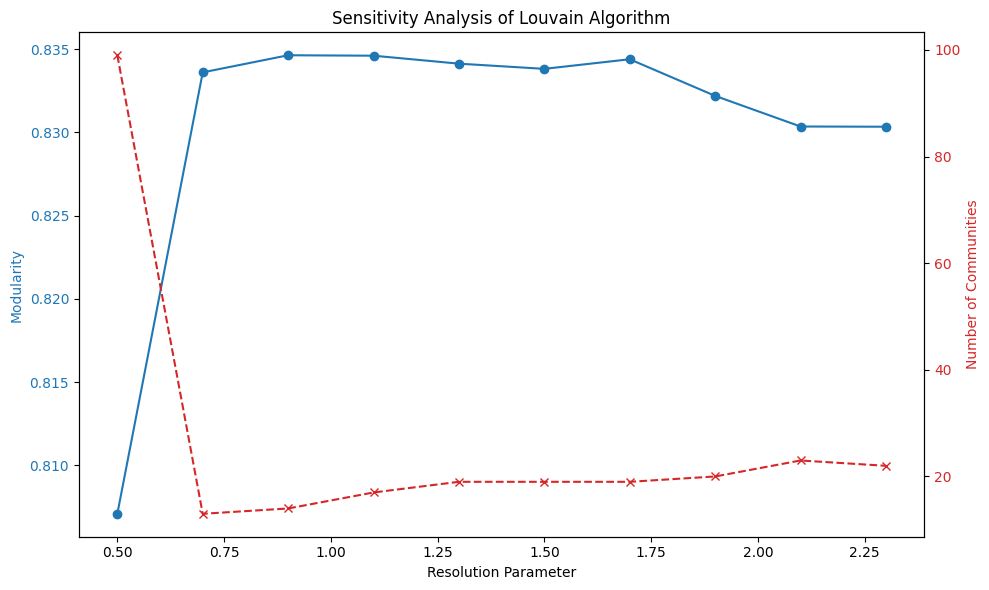

In [ ]:
import community.community_louvain as community_louvain

resolutions = np.arange(0.5, 2.5, 0.2)
modularities = []
num_communities = []

for r in resolutions:
    partition = community_louvain.best_partition(G_facebook, resolution=r)
    modularities.append(community_louvain.modularity(partition, G_facebook))
    num_communities.append(len(set(partition.values())))

# Plot results
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel('Resolution Parameter')
ax1.set_ylabel('Modularity', color=color)
ax1.plot(resolutions, modularities, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Communities', color=color)
ax2.plot(resolutions, num_communities, marker='x', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Sensitivity Analysis of Louvain Algorithm')
fig.tight_layout()
plt.show()

plt.show()



###  Sensitivity Analysis for Infomap (Markov Time Parameter)

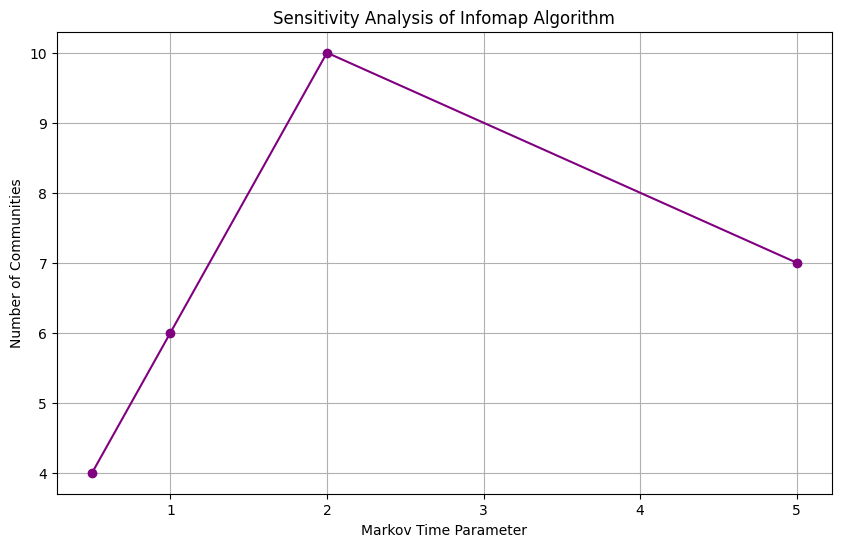

In [ ]:
from infomap import Infomap

markov_times = [0.5, 1, 2, 5]
infomap_communities = []

for mt in markov_times:
    infomap = Infomap("--markov-time {}".format(mt))
    node_id_map = {node: i for i, node in enumerate(G_facebook.nodes())}
    for u, v in G_facebook.edges():
        infomap.addLink(node_id_map[u], node_id_map[v])
    infomap.run()
    infomap_communities.append(infomap.num_top_modules)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(markov_times, infomap_communities, marker='o', color='purple')
plt.xlabel('Markov Time Parameter')
plt.ylabel('Number of Communities')
plt.title('Sensitivity Analysis of Infomap Algorithm')
plt.grid(True)
plt.show()


### Additional Centrality Analysis

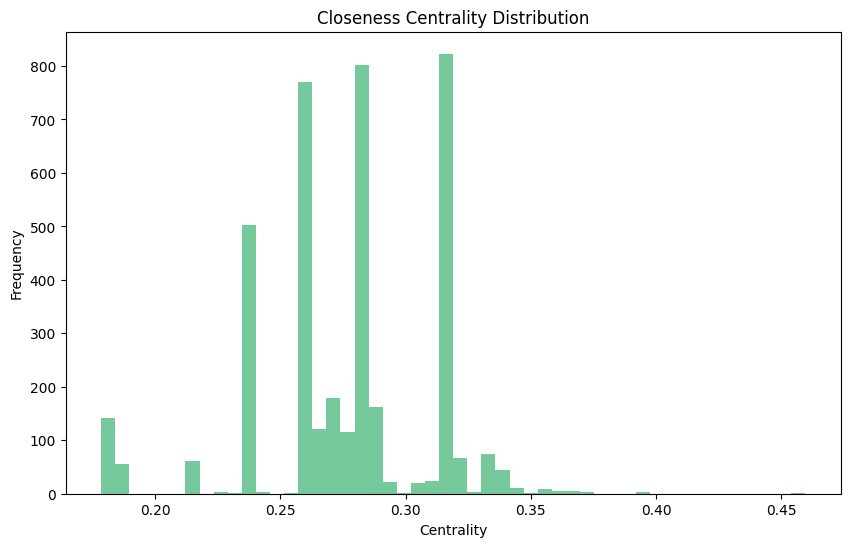

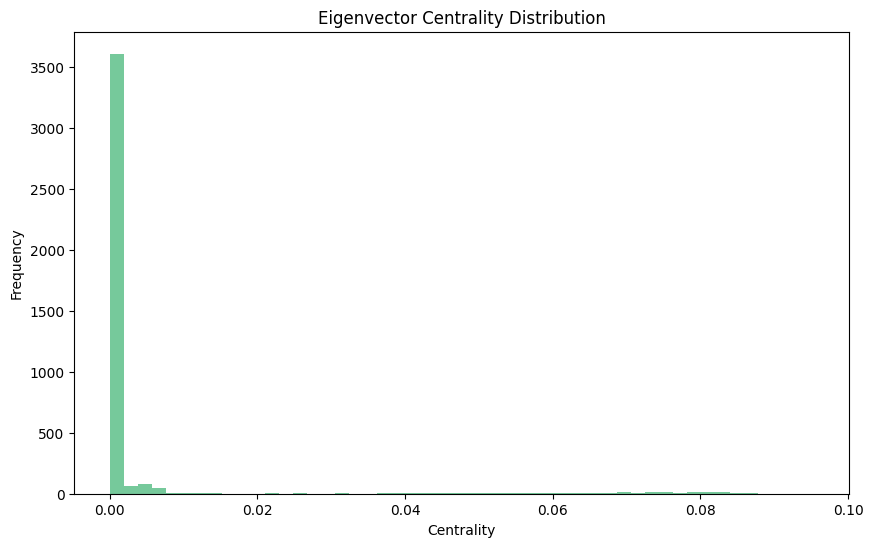

In [ ]:
# Closeness Centrality
closeness_cent = nx.closeness_centrality(G_facebook)

# Eigenvector Centrality
eigenvector_cent = nx.eigenvector_centrality(G_facebook, max_iter=500)

# Visualize distributions
def plot_centrality(centrality, title):
    plt.figure(figsize=(10, 6))
    plt.hist(centrality.values(), bins=50, color='mediumseagreen', alpha=0.7)
    plt.title(title)
    plt.xlabel('Centrality')
    plt.ylabel('Frequency')
    plt.show()

plot_centrality(closeness_cent, 'Closeness Centrality Distribution')
plot_centrality(eigenvector_cent, 'Eigenvector Centrality Distribution')


### Statistical Significance (Wilcoxon Test)